## Install packages

In [2]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=11eaf0ae8122143adb0d1cc8a6e94f4dcbc3c2a63a8f66e788080639095530ad
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=bd82b4a1870a2078e4f5509778c2f15b3cdae3844dd72ce1e636b6c546692e1f
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pyLDAvis sklearn


## Importing libraries

In [3]:
import numpy as np
import pandas as pd
import re
from pprint import pprint
import scipy.cluster.hierarchy as sch
from numpy.ma.core import reshape
from yellowbrick.cluster import SilhouetteVisualizer

# nltk
import nltk
from urllib import request
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.collocations import *
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

# sklearn
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import cohen_kappa_score
from sklearn.manifold import TSNE

#Gensim 
import gensim
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.models import Word2Vec

# plotting 
import matplotlib.pyplot as plt 
import seaborn as sns
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models
%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


## Importing Gutenberg books

In [4]:
url_1 = "https://www.gutenberg.org/cache/epub/108/pg108.txt"
url_2 = "https://www.gutenberg.org/cache/epub/1300/pg1300.txt"
url_3 = "https://www.gutenberg.org/cache/epub/26556/pg26556.txt"
url_4 = "https://www.gutenberg.org/cache/epub/30802/pg30802.txt"
url_5 = "https://www.gutenberg.org/cache/epub/39074/pg39074.txt"

In [5]:
response_1= request.urlopen(url_1)
raw_1= response_1.read().decode('utf8')
raw_1 = raw_1.replace(raw_1[:1439],'')

response_2= request.urlopen(url_2)
raw_2= response_2.read().decode('utf8')
raw_2 = raw_2.replace(raw_2[:2350],'')

response_3= request.urlopen(url_3)
raw_3= response_3.read().decode('utf8')
raw_3 = raw_3.replace(raw_3[:3395],'')

response_4= request.urlopen(url_4)
raw_4= response_4.read().decode('utf8')
raw_4 = raw_4.replace(raw_4[:8501],'')

response_5= request.urlopen(url_5)
raw_5= response_5.read().decode('utf8')
raw_5 = raw_5.replace(raw_5[:2421],'')


In [6]:
book_content = {'The Return of Sherlock Holmes':raw_1,'Riders of the Purple Sage':raw_2 , 'Myths and Marvels of Astronomy':raw_3, 'Commentaries on the Laws of England':raw_4, 'Curiosities of Medical Experience':raw_5}
book_name = ['The Return of Sherlock Holmes', 'Riders of the Purple Sage' , 'Myths and Marvels of Astronomy', 'Commentaries on the Laws of England', 'Curiosities of Medical Experience']
authors = ['Sir Arthur Conan Doyle', 'Zane Grey' ,'Richard A. Proctor','William Blackstone', 'J.G.(John Gideon) Millingen']
genre = ['Fiction', 'Western','Astronomy',' Laws','Medicine']
books = pd.DataFrame()
books['book_name'] = book_content.keys()
books['authors'] = authors
books['book_genre'] = genre
books['book_content'] = book_content.values()
books

,book_name,authors,book_genre,book_content
0,The Return of Sherlock Holmes,Sir Arthur Conan Doyle,Fiction,THE ADVENTURE OF THE EMPTY HOUSE\r\n\r\n\r\n ...
1,Riders of the Purple Sage,Zane Grey,Western,CHAPTER I.\r\nLASSITER\r\n\r\n\r\nA sharp clip...
2,Myths and Marvels of Astronomy,Richard A. Proctor,Astronomy,MYTHS AND MARVELS\r\n\r\nOF\r\n\r\nASTRONOMY\r...
3,Commentaries on the Laws of England,William Blackstone,Laws,INTRODUCTION.\r\n\r\nSECTION THE FIRST.\r\n\r\...
4,Curiosities of Medical Experience,J.G.(John Gideon) Millingen,Medicine,e of the first edition of this work has induce...


In [7]:
books_input=[]
books_chosen =[]
books_no = int(input("Enter numbers of books: "))
print(books['book_name'])
for i in range (books_no):  
  x = input("kindly choose one book from the list, or press e to escape  ")
  if x in book_name:
    books_input.append(x)
    books_chosen.append(book_content[x])
  elif x == 'e':
    break
  else:
    print('sorry, invalid book name')
print('you have choosed these books :  ', books_input)
partition_no = input("Enter the number of partitions: ")
word_no = input("Enter the number of words: ")

Enter numbers of books: 5
0          The Return of Sherlock Holmes
1              Riders of the Purple Sage
2         Myths and Marvels of Astronomy
3    Commentaries on the Laws of England
4      Curiosities of Medical Experience
Name: book_name, dtype: object
kindly choose one book from the list, or press e to escape  The Return of Sherlock Holmes
kindly choose one book from the list, or press e to escape  Riders of the Purple Sage
kindly choose one book from the list, or press e to escape  Myths and Marvels of Astronomy
kindly choose one book from the list, or press e to escape  Commentaries on the Laws of England
kindly choose one book from the list, or press e to escape  Curiosities of Medical Experience
you have choosed these books :   ['The Return of Sherlock Holmes', 'Riders of the Purple Sage', 'Myths and Marvels of Astronomy', 'Commentaries on the Laws of England', 'Curiosities of Medical Experience']
Enter the number of partitions: 200
Enter the number of words: 100


## Cleaning

In [8]:
def Cleaning(books_chosen,books_input):
  #corpus = [] #creating empty list
  dict_1 ={}  #creating empty dictionary
  #cleaning the books
  for i in range(len(books_input)):
    #removing all letters except a to z and A to Z
    clean = re.sub('[^a-zA-Z]', ' ', books_chosen[i])
    #converting all characters into lowercase
    clean = clean.lower()
    #removing whitespace
    clean = clean.strip()
    #spliting the words by whitespace
    clean = re.split(' ',clean)
    # removing all stop words and return the word into thier orignal
    clean = [word for word in clean if not word in set(stopwords.words('english'))]
    lemmatizer = WordNetLemmatizer()
    clean = [lemmatizer.lemmatize(w) for w in clean]
    #puting corpus list into dictionary
    dict_1[i]=clean 
    #removing all "" from list
    dict_1[i] = [i for i in dict_1[i] if i]
  return dict_1

## Partitioning

In [9]:
def partitions(books_chosen,books_input,partition_no,word_no):
  df=pd.DataFrame()
  dict_1 = Cleaning(books_chosen,books_input)
  for key in range(len(books_input)):
    x=books_input[key]
    dict_1[x]=dict_1[key]
    del dict_1[key]  
    #make 200 partitions each partitions contain 100 words
  for x in books_input:
    df[x] = [dict_1[x][i*partition_no:i*partition_no+word_no] for i in range(partition_no)]
    #merging the 2 columns into one column
  df=df.stack().reset_index()
    #delete column level_0
  df.drop('level_0',inplace=True,axis=1)
    #rename the columns in dataframe
  df.rename(columns={0:"Words","level_1":"books name"},inplace=True)
  for i in range(len(df)):
    df.Words[i] = ' '.join(map(str,df.Words[i]))
  df = shuffle(df)
  return df

In [10]:
data = partitions(books_chosen,books_input,int(partition_no),int(word_no))
data

,books name,Words
160,The Return of Sherlock Holmes,valuable could find course could definitely pr...
417,Myths and Marvels of Astronomy,little known swedenborg indeed little known as...
522,Myths and Marvels of Astronomy,enlargement idea theological difficulty scienc...
669,Curiosities of Medical Experience,hooped pot shall ten hoop make felony drink sm...
545,The Return of Sherlock Holmes,round spent night town came yesterday report r...
...,...,...
420,The Return of Sherlock Holmes,end building facing way lord saltire bed also ...
762,Myths and Marvels of Astronomy,pierce harvard satisfactorily demonstrated sta...
667,Myths and Marvels of Astronomy,sun though lightly nucleus within mile surface...
635,The Return of Sherlock Holmes,valet maid frequently genteel ruffian gained c...


##Transformation

1 BOW

In [11]:
vectorizer = CountVectorizer(ngram_range = (1, 2))
x_bow = vectorizer.fit_transform(data['Words']).toarray()

 2 TFIDF

In [12]:
tfidf  = TfidfVectorizer(ngram_range=(1,2))
x_tfidf = tfidf.fit_transform(data['Words']).toarray()

3 LDA

In [13]:
# create list 
docs = [word.split() for word in data.Words]
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

# Bag-of-words representation of the documents.
bow_corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(bow_corpus))

Number of unique tokens: 864
Number of documents: 1000


In [14]:
# Build lda model
ldamodel = LdaModel(corpus=bow_corpus, 
                    id2word=dictionary, 
                    chunksize =1000,
                    random_state=0,
                    update_every=1, 
                    passes =20, 
                    alpha='auto',
                    eta='auto', 
                    iterations=20, 
                    num_topics =5, 
                    per_word_topics = True,
                    eval_every = None)

In [15]:
# print topics and the keywords of each topic and their weights in its topic
pprint(ldamodel.print_topics())

[(0,
  '0.014*"one" + 0.013*"time" + 0.012*"would" + 0.011*"may" + 0.009*"day" + '
  '0.008*"earth" + 0.008*"comet" + 0.008*"great" + 0.007*"sun" + 0.007*"many"'),
 (1,
  '0.024*"jane" + 0.018*"lassiter" + 0.013*"venter" + 0.012*"woman" + '
  '0.010*"one" + 0.010*"withersteen" + 0.009*"rider" + 0.009*"said" + '
  '0.009*"man" + 0.008*"know"'),
 (2,
  '0.023*"holmes" + 0.017*"said" + 0.016*"mr" + 0.014*"upon" + 0.014*"man" + '
  '0.013*"one" + 0.013*"would" + 0.011*"could" + 0.010*"well" + 0.009*"u"'),
 (3,
  '0.026*"venter" + 0.023*"star" + 0.017*"ring" + 0.012*"would" + '
  '0.010*"black" + 0.009*"dark" + 0.009*"could" + 0.009*"one" + 0.009*"stone" '
  '+ 0.008*"horse"'),
 (4,
  '0.044*"law" + 0.018*"king" + 0.017*"footnote" + 0.015*"c" + '
  '0.014*"parliament" + 0.013*"upon" + 0.012*"right" + 0.010*"common" + '
  '0.010*"statute" + 0.010*"one"')]


In [16]:
# put the probability of each document in dataframe consist of 5 column corrosponding to the topic 
df =pd.DataFrame()
df['topics'] = ldamodel.get_document_topics(bow_corpus)
sf = pd.DataFrame(data=df['topics'])
af = pd.DataFrame()

for i in range(5):
    af[str(i)]=[]

frames = [sf,af]
af = pd.concat(frames).fillna(0)

for i in range(1000):
  for j in range(len(df['topics'][i])):
    af[str(df['topics'][i][j][0])].loc[i] = df['topics'][i][j][1]
af.drop('topics', axis = 1, inplace =True)
af

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,0,1,2,3,4
0,0.000000,0.000000,0.995438,0.000000,0.000000
1,0.949708,0.046548,0.000000,0.000000,0.000000
2,0.995341,0.000000,0.000000,0.000000,0.000000
3,0.596558,0.000000,0.191727,0.000000,0.208099
4,0.000000,0.000000,0.994853,0.000000,0.000000
...,...,...,...,...,...
995,0.000000,0.000000,0.994682,0.000000,0.000000
996,0.662338,0.000000,0.000000,0.333796,0.000000
997,0.631903,0.000000,0.000000,0.364358,0.000000
998,0.062029,0.000000,0.930551,0.000000,0.000000


In [17]:
# visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel,bow_corpus,dictionary)
vis

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.064849 -0.085556       1        1  28.893951
2     -0.038948  0.065324       2        1  22.847571
4      0.198118  0.034586       3        1  21.022121
1     -0.114396  0.069788       4        1  15.317286
3     -0.109622 -0.084142       5        1  11.919072, topic_info=        Term        Freq       Total Category  logprob  loglift
379      law  525.000000  525.000000  Default  30.0000  30.0000
175   holmes  288.000000  288.000000  Default  29.0000  29.0000
274   venter  276.000000  276.000000  Default  28.0000  28.0000
204     jane  198.000000  198.000000  Default  27.0000  27.0000
327     star  208.000000  208.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
155      one   56.415486  629.374708   Topic5  -4.7338  -0.2850
149     made   41.352064  237.333965   Topic5  -5.0445   0.3797
122    place   34.442088  157.366196   Topic5  -5.2273   0.6077
736  pyramid   33.128835  121.940344   Topic5  -5.2662   0.8239
249     upon   35.316964  511.674303   Topic5  -5.2022  -0.5463

[316 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
99        1  0.095261    act
99        2  0.042338    act
99        3  0.804425    act
99        4  0.042338    act
99        5  0.021169    act
...     ...       ...    ...
250       1  0.130889  young
250       2  0.727163  young
250       3  0.029087  young
250       4  0.087260  young
250       5  0.014543  young

[939 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 2, 4])

4 Word Embedding


Word2Vec

In [18]:
data['Words']= data['Words'].apply(lambda x: x.split(' '))

word2vec_model = gensim.models.Word2Vec(data['Words'] , min_count = 1, window = 5)
word2vec_model

word2vec_model.wv.most_similar('good', topn=10)

/usr/local/lib/python3.8/dist-packages/gensim/matutils.py:737: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if np.issubdtype(vec.dtype, np.int):


[('one', 0.9999683499336243),
 ('would', 0.9999641180038452),
 ('could', 0.9999632835388184),
 ('upon', 0.9999624490737915),
 ('time', 0.9999624490737915),
 ('man', 0.9999579787254333),
 ('much', 0.9999575614929199),
 ('little', 0.999956488609314),
 ('like', 0.9999562501907349),
 ('say', 0.9999560117721558)]

In [19]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
x_word2vec = vectorize(data['Words'], model=word2vec_model) #vectorized_docs
len(x_word2vec), len(x_word2vec[0])

(1000, 100)

Streaming output truncated to the last 5000 lines.
<ipython-input-20-d342b8efa06f>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  tokens.append(model[word])
<ipython-input-20-d342b8efa06f>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  tokens.append(model[word])
<ipython-input-20-d342b8efa06f>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  tokens.append(model[word])
<ipython-input-20-d342b8efa06f>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  tokens.append(model[word])
<ipython-input-20-d342b8efa06f>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  tokens.append(model[word])
<ipython-input

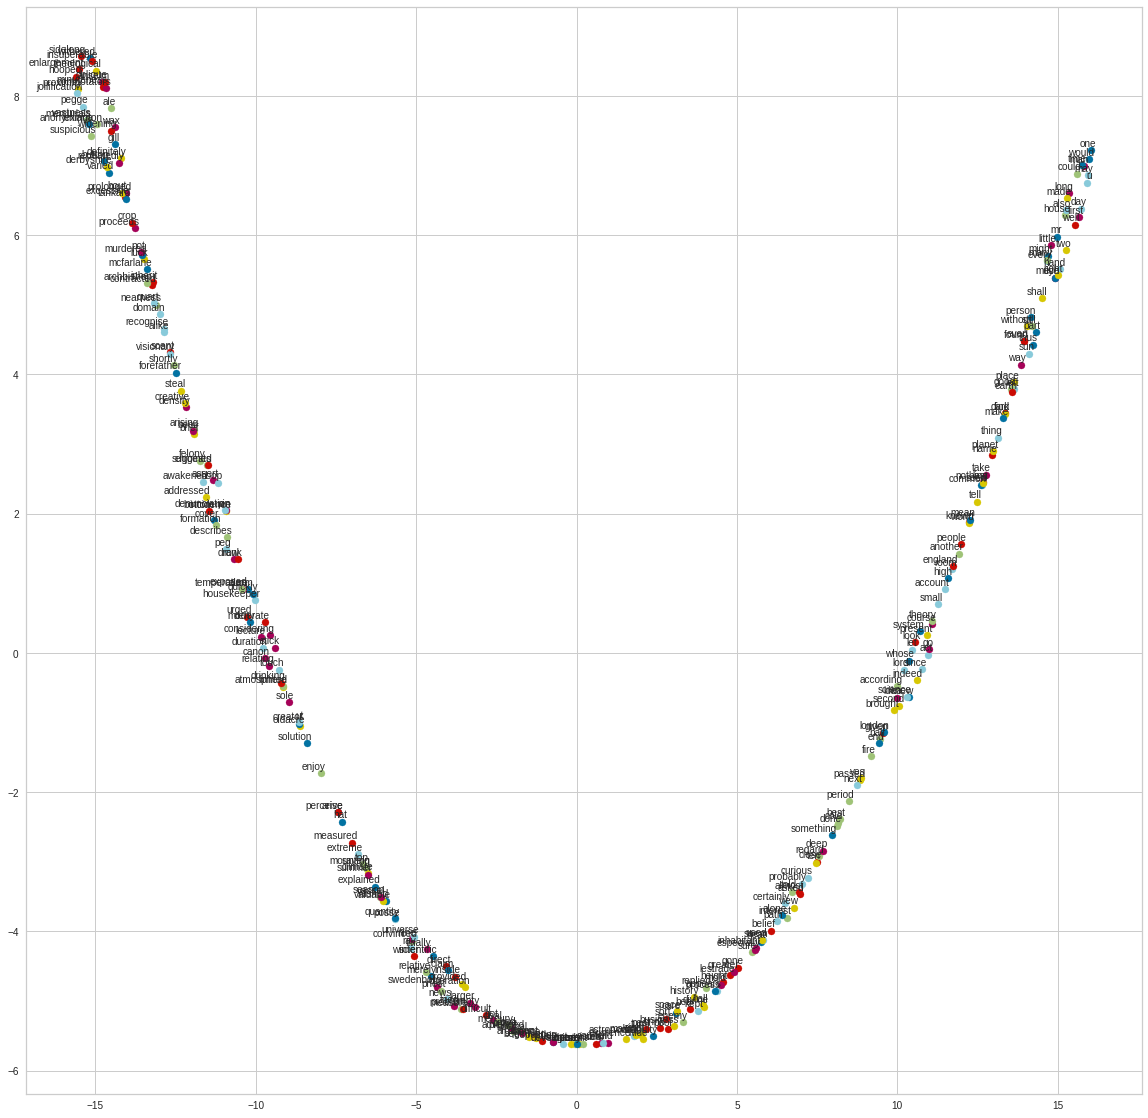

In [20]:
#visualization for word2vec
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=350, random_state=23)
    new_values = tsne_model.fit_transform(tokens[:300])

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(20, 20)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    return (plt.show())

tsne_plot(word2vec_model)

## Label encoder

In [21]:
le = LabelEncoder()
y = le.fit_transform(data['books name'])
y

array([4, 2, 2, 1, 4, 3, 4, 3, 3, 4, 2, 3, 1, 0, 3, 4, 0, 4, 0, 4, 2, 4,
       0, 3, 3, 0, 4, 0, 4, 0, 3, 4, 1, 1, 3, 2, 2, 3, 0, 2, 3, 2, 2, 3,
       4, 2, 1, 4, 4, 2, 1, 2, 2, 3, 1, 4, 2, 4, 1, 3, 1, 0, 0, 0, 1, 4,
       1, 0, 1, 2, 1, 4, 3, 3, 1, 3, 4, 2, 0, 1, 0, 1, 3, 1, 3, 4, 4, 2,
       0, 2, 4, 3, 4, 2, 4, 4, 2, 0, 2, 0, 3, 1, 2, 4, 2, 1, 4, 0, 4, 0,
       1, 0, 1, 1, 1, 0, 2, 1, 2, 1, 2, 0, 3, 4, 1, 0, 2, 1, 1, 2, 0, 4,
       2, 1, 3, 2, 4, 3, 1, 4, 4, 0, 1, 1, 1, 1, 0, 3, 2, 3, 4, 1, 0, 2,
       3, 1, 3, 0, 4, 0, 2, 2, 1, 3, 0, 1, 3, 1, 3, 4, 1, 4, 2, 2, 2, 4,
       3, 4, 3, 4, 1, 4, 2, 2, 0, 1, 1, 3, 3, 1, 2, 2, 4, 4, 1, 3, 4, 1,
       4, 0, 3, 1, 3, 1, 4, 2, 2, 2, 4, 0, 2, 4, 3, 1, 1, 0, 4, 1, 1, 4,
       4, 3, 1, 3, 0, 0, 4, 4, 0, 4, 0, 3, 3, 0, 1, 3, 0, 3, 4, 3, 1, 2,
       3, 2, 2, 3, 0, 3, 4, 1, 3, 2, 2, 2, 4, 1, 4, 2, 3, 4, 2, 0, 1, 4,
       2, 0, 4, 1, 3, 2, 3, 0, 4, 0, 3, 4, 4, 0, 0, 1, 3, 0, 1, 0, 1, 2,
       0, 4, 2, 0, 4, 1, 1, 4, 3, 0, 1, 0, 0, 1, 3,

## Dimensionality reduction

In [22]:
pca = PCA(n_components = 2)
x_bow_pca = pca.fit_transform(x_bow)
x_tfidf_pca = pca.fit_transform(x_tfidf)
af_pca =pca.fit_transform(af)
x_word2vec_pca = pca.fit_transform(x_word2vec)

In [23]:
af_pca

array([[-0.39948994,  0.70177333],
       [ 0.70356236, -0.07437036],
       [ 0.74654669, -0.08302311],
       ...,
       [ 0.4360357 , -0.0282146 ],
       [-0.32719238,  0.65091117],
       [ 0.74430871, -0.08274987]])

## Clustering

1 K-Means

In [24]:
def elbow(x):
  wcss=[]
  for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(x_bow_pca)
    wcss.append(kmeans.inertia_)
  plt.plot(range(1,11),wcss)
  plt.title('Elbow method')
  plt.xlabel('Number of clusters')
  plt.ylabel('wcss')

In [25]:
def Silhouette(x):
  Silhouette_Score =[]
  for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=1, random_state=100)
    cluster_labels = kmeans.fit_predict(x)
    silhouette_avg = silhouette_score(x, cluster_labels,metric="euclidean",sample_size=1000,random_state=0)
    Silhouette_Score.append(silhouette_avg )
    # print(
    #       "For n_clusters =",
    #       i,
    #       "The average silhouette_score is :",
    #       silhouette_avg,
    #   )
  plt.plot(range(2,11),Silhouette_Score)
  plt.title('Silhouette score vs Numbers of clusters')
  plt.xlabel('Numbers of clusters')
  plt.ylabel('Silhouette score')
  plt.legend()
  return silhouette_avg

In [26]:
def kmeans(n_clusters,x):
  kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=1, random_state=100)
  y_kmeans = kmeans.fit_predict(x)
  plt.scatter(x[y_kmeans==0,0],x[y_kmeans==0,1],c = 'red')
  plt.scatter(x[y_kmeans==1,0],x[y_kmeans==1,1],c = 'blue')
  plt.scatter(x[y_kmeans==2,0],x[y_kmeans==2,1],c = 'Green')
  plt.scatter(x[y_kmeans==3,0],x[y_kmeans==3,1],c = 'cyan')
  plt.scatter(x[y_kmeans==4,0],x[y_kmeans==4,1],c ='purple')
  return y_kmeans

In [27]:
def true_label(x,y):
  plt.scatter(x[y==0,0],x[y==0,1],c = 'red')
  plt.scatter(x[y==1,0],x[y==1,1],c = 'blue')
  plt.scatter(x[y==2,0],x[y==2,1],c = 'Green')
  plt.scatter(x[y==3,0],x[y==3,1],c = 'cyan')
  plt.scatter(x[y==4,0],x[y==4,1],c = 'purple')

1.1 BOW

Text(0.5, 0.98, 'Kmeans BOW')

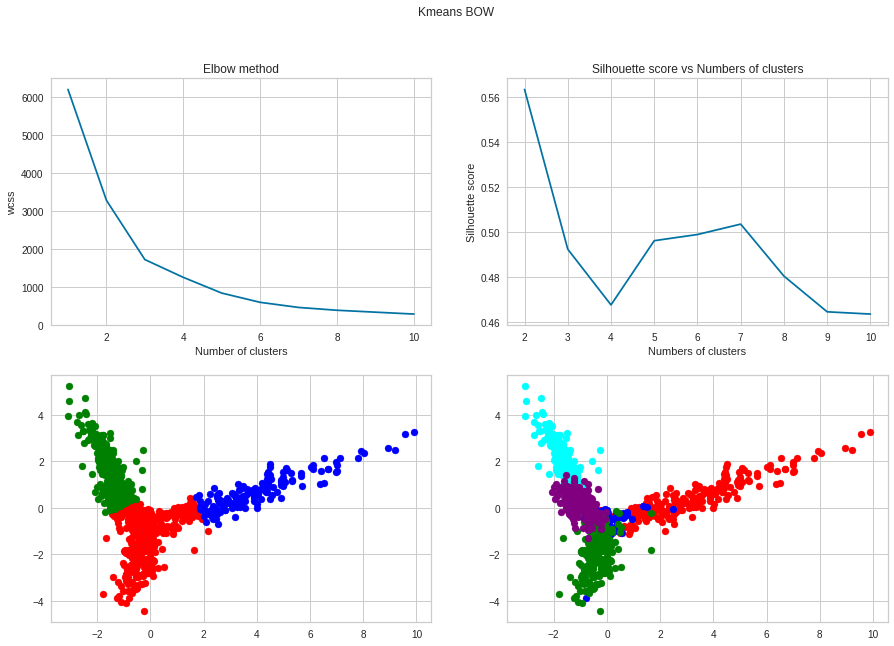

In [28]:
from IPython.core.pylabtools import figsize
figsize(15,10)
plt.subplot(2,2,1)
elbow(x_bow_pca)
plt.subplot(2,2,2)
Silhouette(x_bow_pca)
plt.subplot(2,2,3)
kmeans(3,x_bow_pca)
plt.subplot(2,2,4)
true_label(x_bow_pca,y)

plt.suptitle('Kmeans BOW')

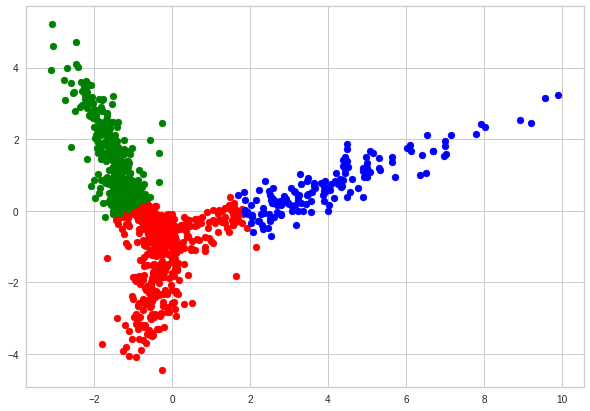

In [29]:
figsize(10,7)
y_kmeans_bow = kmeans(3,x_bow_pca)

1.2 TFIDF

Text(0.5, 0.98, 'Kmeans TFIDF')

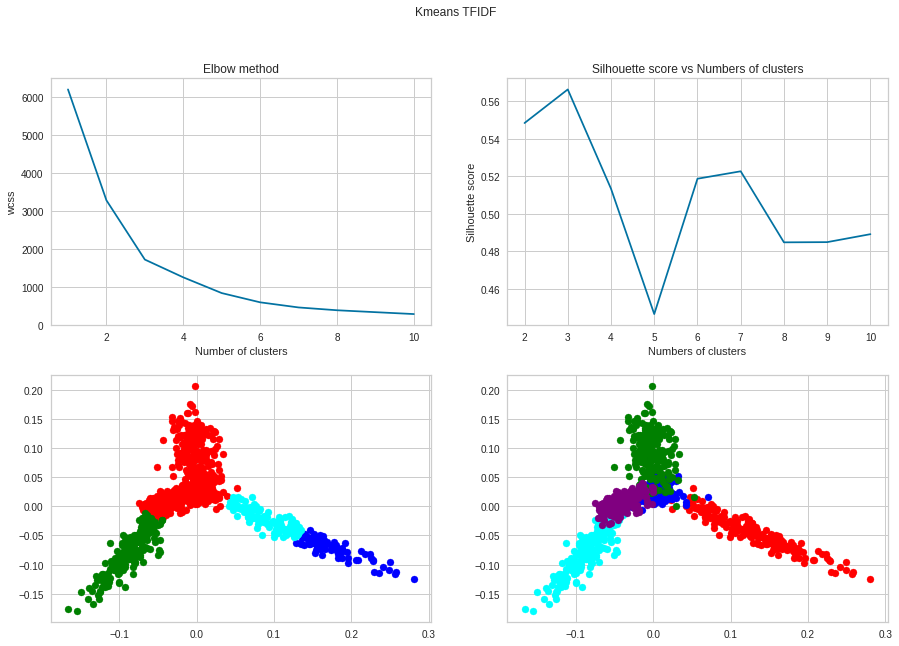

In [30]:
figsize(15,10)
plt.subplot(2,2,1)
elbow(x_tfidf_pca)
plt.subplot(2,2,2)
Silhouette(x_tfidf_pca)
plt.subplot(2,2,3)
kmeans(4,x_tfidf_pca)
plt.subplot(2,2,4)
true_label(x_tfidf_pca,y)
plt.suptitle('Kmeans TFIDF')

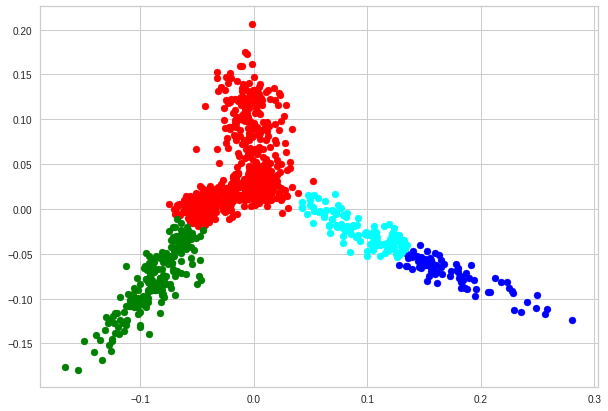

In [31]:
figsize(10,7)
y_kmeans_tfidf = kmeans(4,x_tfidf_pca)

1.3 LDA (Latent Dirichlet Allocation)

Text(0.5, 0.98, 'Kmeans LDA')

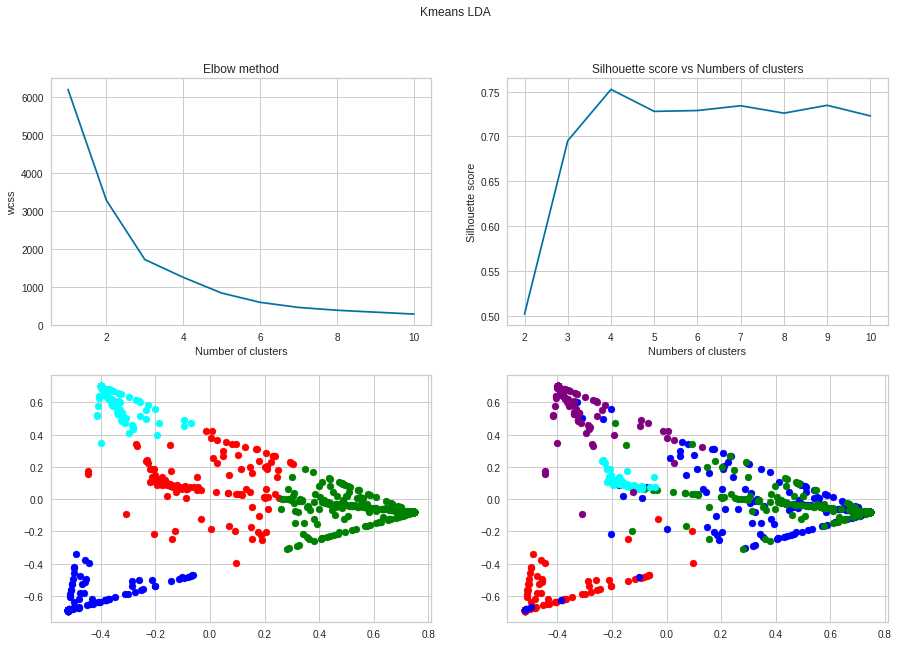

In [32]:
figsize(15,10)
plt.subplot(2,2,1)
elbow(af_pca)
plt.subplot(2,2,2)
Silhouette(af_pca)
plt.subplot(2,2,3)
kmeans(4,af_pca)
plt.subplot(2,2,4)
true_label(af_pca,y)
plt.suptitle('Kmeans LDA')

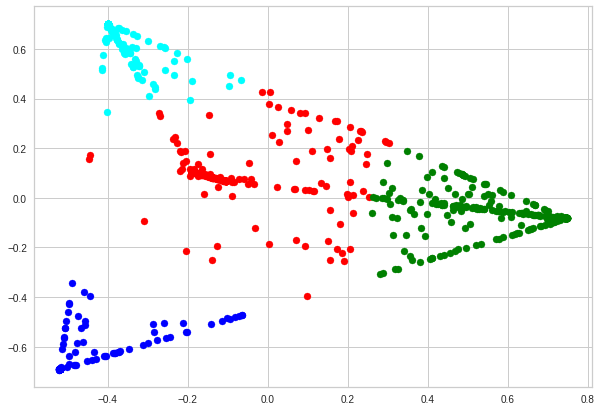

In [33]:
figsize(10,7)
y_kmeans_lda = kmeans(4,af_pca)

1.4 Word2Vec

Text(0.5, 0.98, 'Kmeans Word2vec')

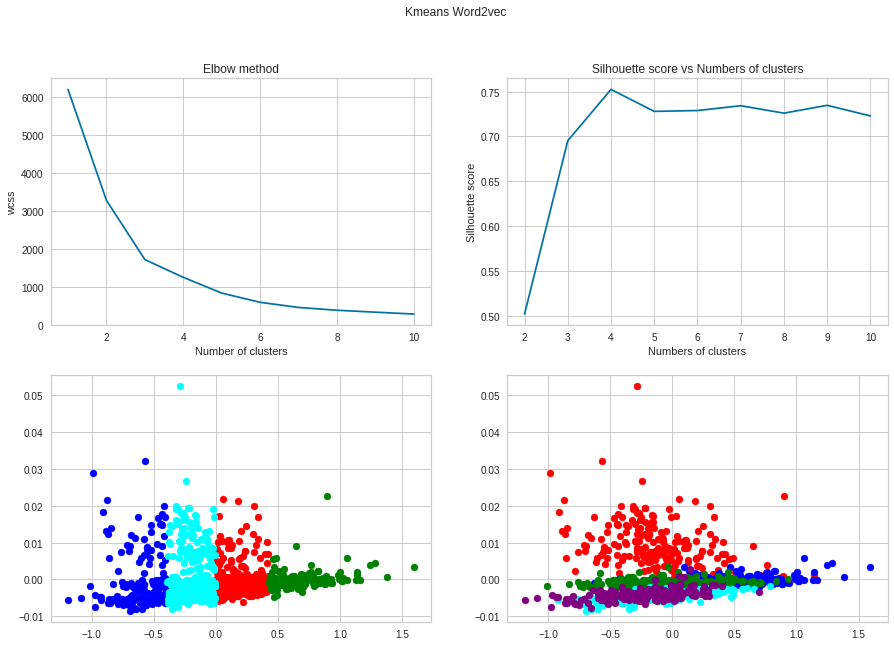

In [34]:
figsize(15,10)
plt.subplot(2,2,1)
elbow(af_pca)
plt.subplot(2,2,2)
Silhouette(af_pca)
plt.subplot(2,2,3)
kmeans(4,x_word2vec_pca)
plt.subplot(2,2,4)
true_label(x_word2vec_pca,y)
plt.suptitle('Kmeans Word2vec')

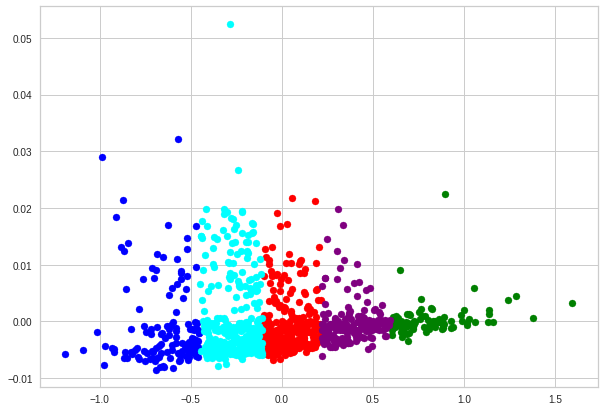

In [35]:
figsize(10,7)
y_kmeans_word2vec = kmeans(5,x_word2vec_pca)

2 EM 
(Expectation Maximization)

In [36]:
def EM(n_components,x):
  EM = GaussianMixture(n_components= n_components, random_state= 150)
  clusters = EM.fit_predict(x)

  plt.scatter(x[clusters==0,0],x[clusters==0,1],c = 'red')
  plt.scatter(x[clusters==1,0],x[clusters==1,1],c = 'blue')
  plt.scatter(x[clusters==2,0],x[clusters==2,1],c = 'Green')
  plt.scatter(x[clusters==3,0],x[clusters==3,1],c = 'cyan')
  plt.scatter(x[clusters==4,0],x[clusters==4,1])
  return clusters

In [37]:
def Silhouette_EM(x):
  Silhouette_Score =[]
  for i in range(2, 11):
    EM = GaussianMixture(n_components= i, random_state= 150)
    clusters = EM.fit_predict(x)
    silhouette_avg = silhouette_score(x, clusters,metric="euclidean",sample_size=1000,random_state=0)
    Silhouette_Score.append(silhouette_avg )
    # print(
    #       "For n_clusters =",
    #       i,
    #       "The average silhouette_score is :",
    #       silhouette_avg,
    #   )
  plt.plot(range(2,11),Silhouette_Score)
  plt.title('Silhouette score vs Numbers of clusters')
  plt.xlabel('Numbers of clusters')
  plt.ylabel('Silhouette score')
  plt.legend()
  return silhouette_avg

2.1 BOW with EM

Text(0.5, 0.98, 'EM BOW')

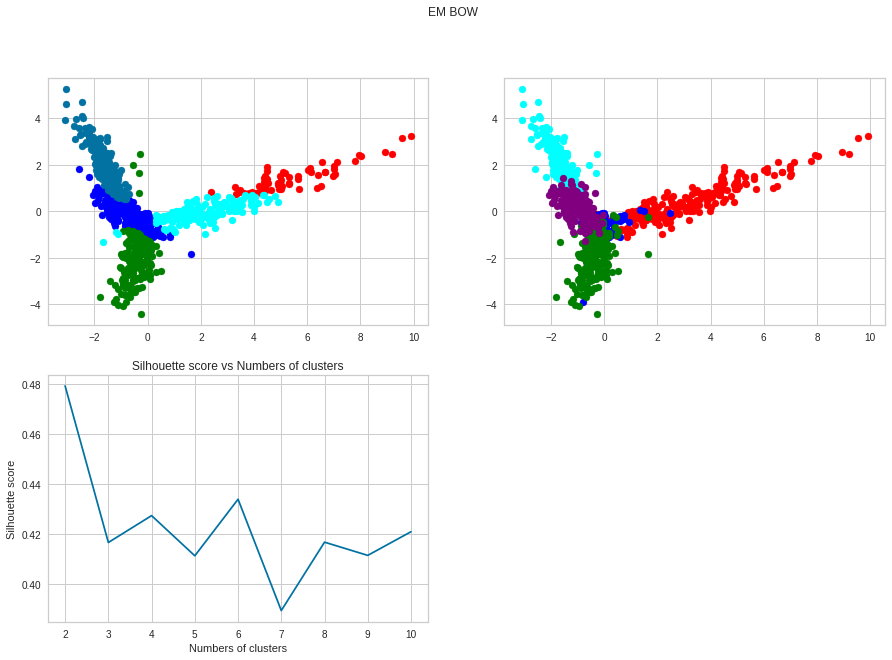

In [38]:
figsize(15,10)
plt.subplot(2,2,1)
EM(5,x_bow_pca)
plt.subplot(2,2,2)
true_label(x_bow_pca,y)
plt.subplot(2,2,3)
Silhouette_EM(x_bow_pca)
plt.suptitle('EM BOW')

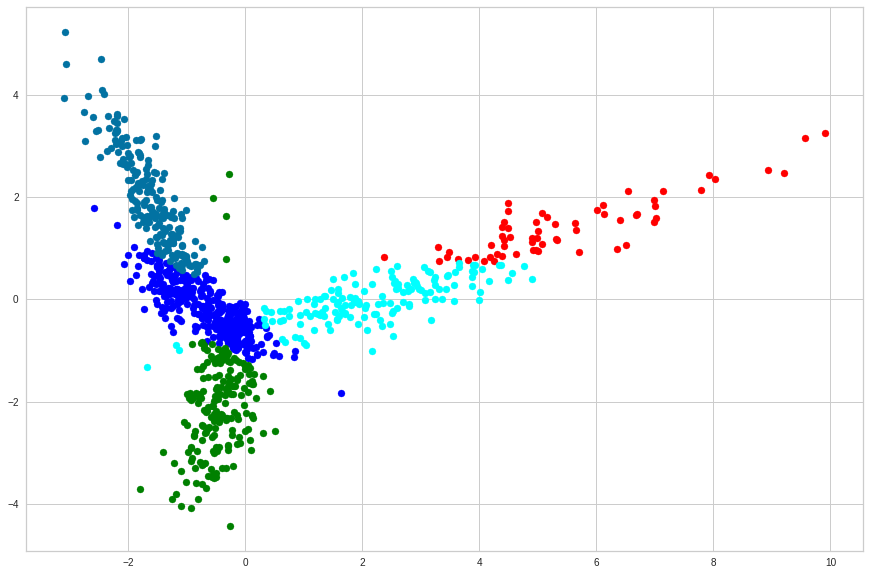

In [39]:
y_em_bow = EM(5,x_bow_pca)

2.2 TFIDF

Text(0.5, 0.98, 'EM TFIDF')

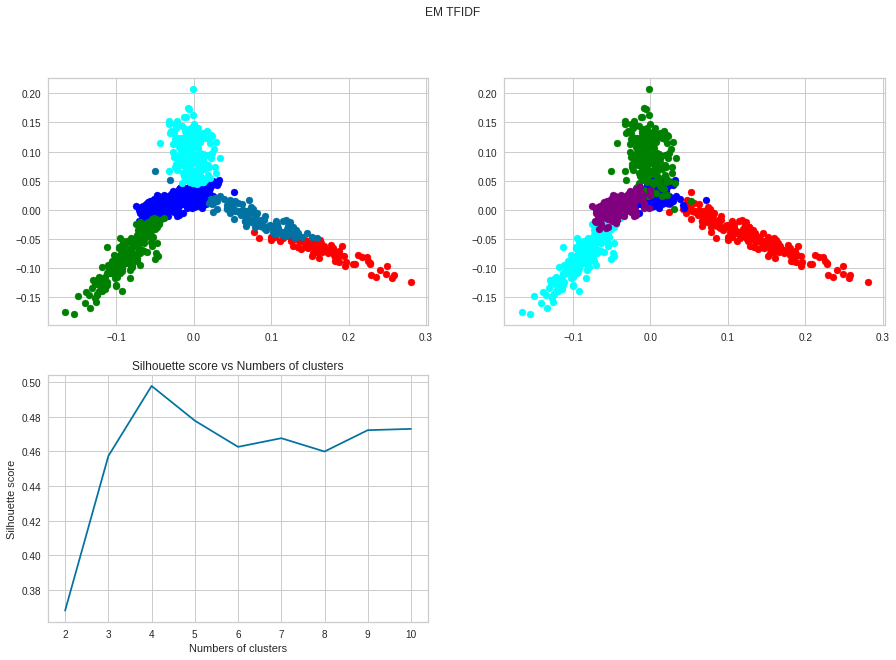

In [40]:
figsize(15,10)
plt.subplot(2,2,1)
EM(5,x_tfidf_pca)
plt.subplot(2,2,2)
true_label(x_tfidf_pca,y)
plt.subplot(2,2,3)
Silhouette_EM(x_tfidf_pca)
plt.suptitle('EM TFIDF')

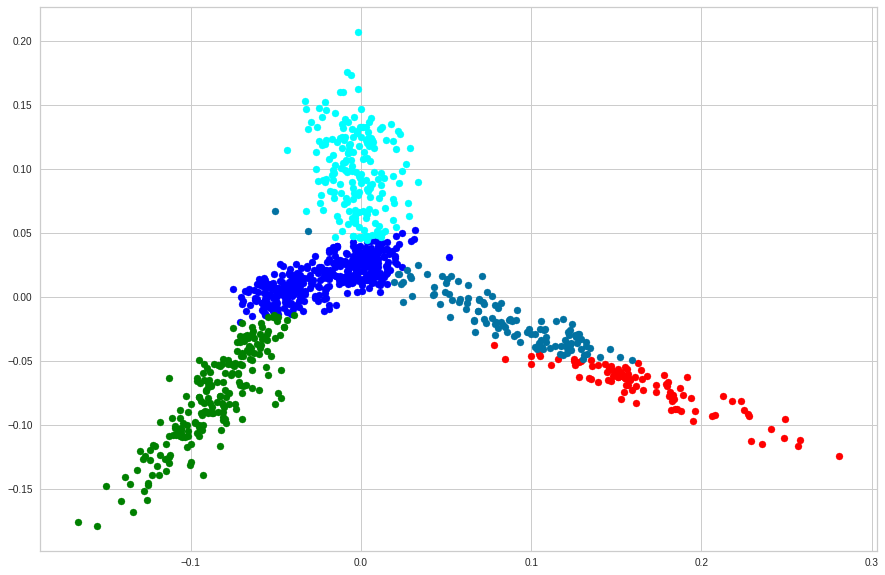

In [41]:
y_em_tfidf = EM(5,x_tfidf_pca)

2.3 LDA

Text(0.5, 0.98, 'EM LDA')

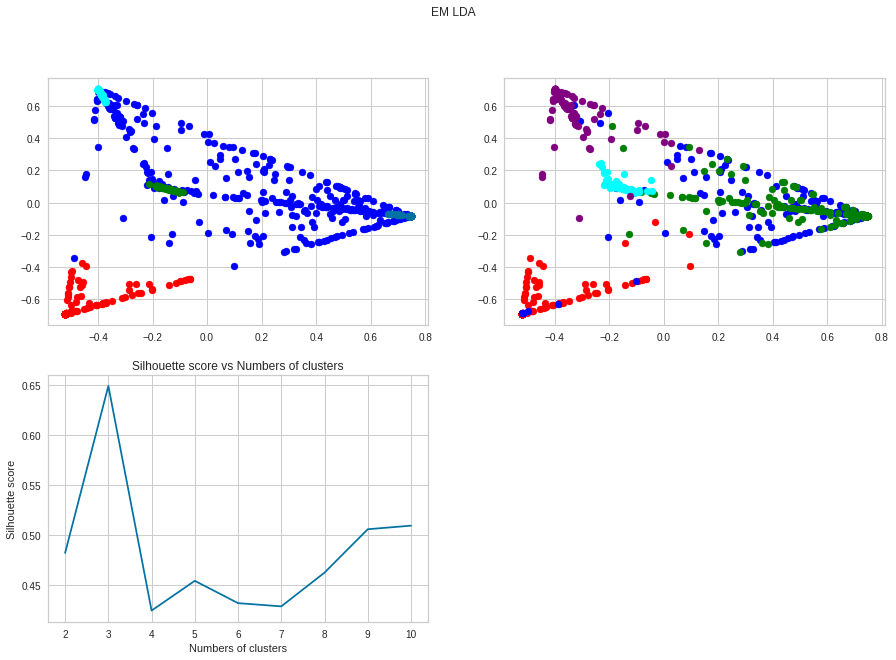

In [42]:
figsize(15,10)
plt.subplot(2,2,1)
EM(5,af_pca)
plt.subplot(2,2,2)
true_label(af_pca,y)
plt.subplot(2,2,3)
Silhouette_EM(af_pca)
plt.suptitle('EM LDA')

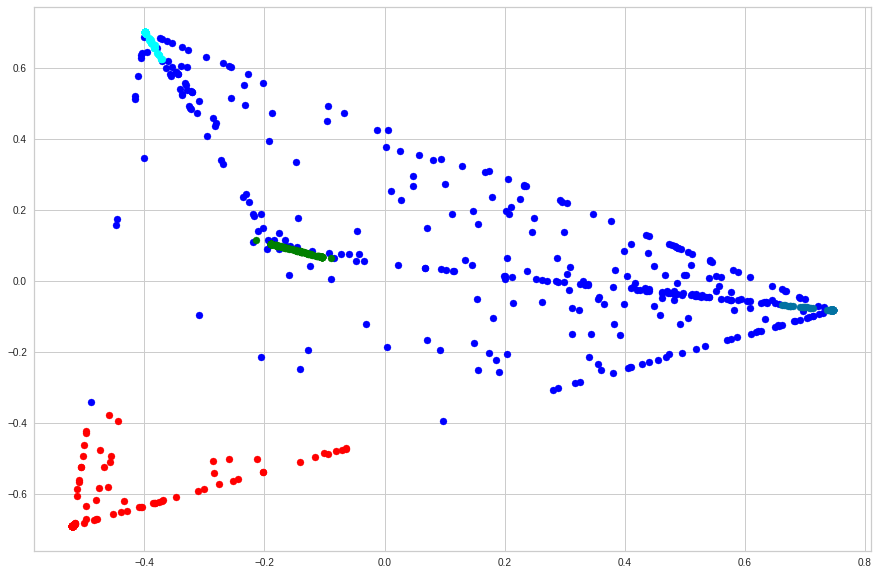

In [43]:
y_em_lda = EM(5,af_pca)

2.4 Word2Vec with EM

Text(0.5, 0.98, 'EM word2vec')

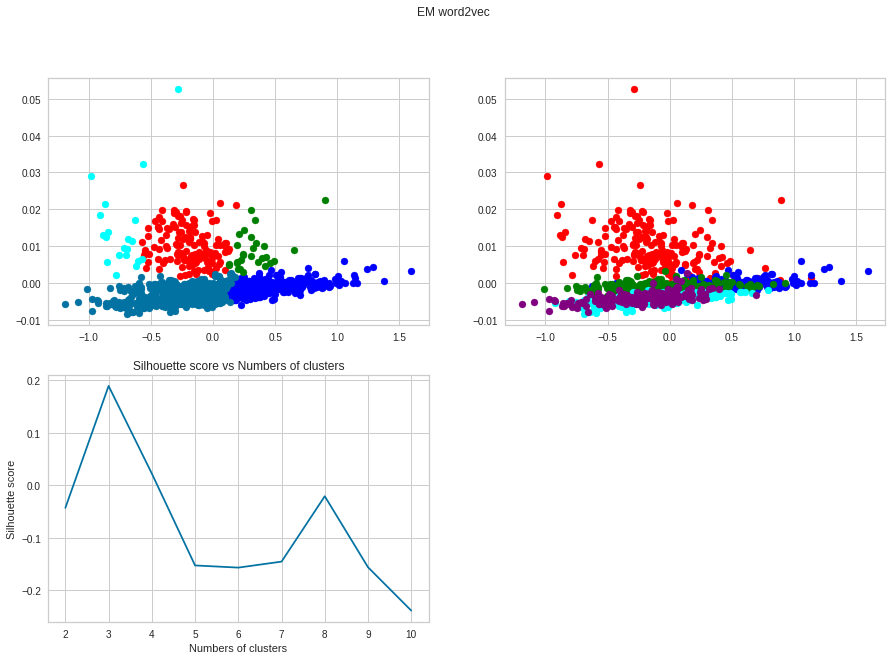

In [44]:
figsize(15,10)
plt.subplot(2,2,1)
EM(5,x_word2vec_pca)
plt.subplot(2,2,2)
true_label(x_word2vec_pca,y)
plt.subplot(2,2,3)
Silhouette_EM(x_word2vec_pca)
plt.suptitle('EM word2vec')

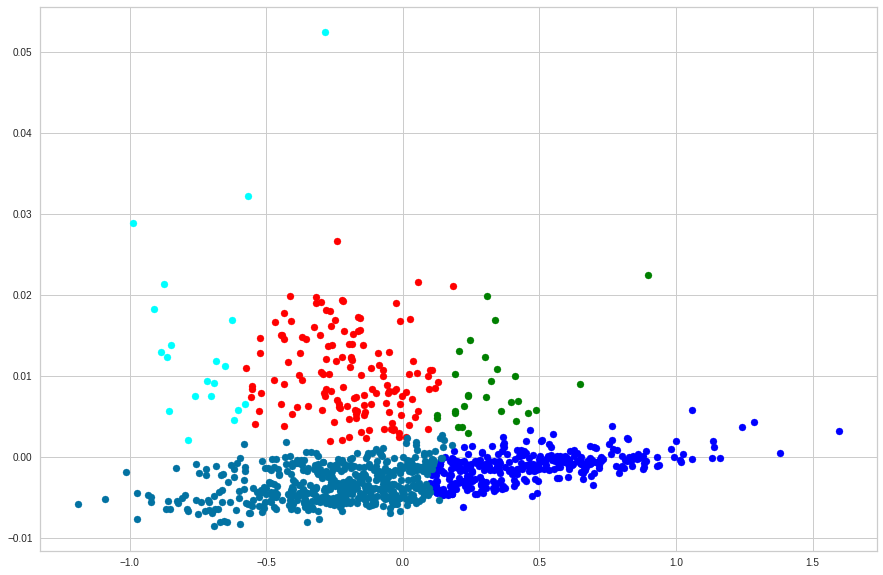

In [45]:
y_em_word2vec = EM(5,x_word2vec_pca)

3 Hierarchical

In [46]:
def dendrogram(x):
  dendrogram = sch.dendrogram(sch.linkage(x, method = 'ward'))
  plt.title('Dendrogram')
  plt.xlabel('Words')
  plt.ylabel('Euclidean distance') 

In [47]:
def HC(n_clusters,x):
  hc = AgglomerativeClustering(n_clusters = n_clusters, affinity ='euclidean', linkage = 'ward')
  y_hc = hc.fit_predict(x)
  plt.scatter(x[y_hc==0,0],x[y_hc==0,1])
  plt.scatter(x[y_hc==1,0],x[y_hc==1,1])
  plt.scatter(x[y_hc==2,0],x[y_hc==2,1])
  plt.scatter(x[y_hc==3,0],x[y_hc==3,1])
  plt.scatter(x[y_hc==4,0],x[y_hc==4,1])
  return y_hc

In [48]:
def Silhouette_hc(x):
  Silhouette_Score =[]
  for i in range(2, 11):
    hc = AgglomerativeClustering(n_clusters = i, affinity ='euclidean', linkage = 'ward')
    y_hc = hc.fit_predict(x)
    silhouette_avg = silhouette_score(x, y_hc,metric="euclidean",sample_size=1000,random_state=0)
    Silhouette_Score.append(silhouette_avg )
    # print(
    #       "For n_clusters =",
    #       i,
    #       "The average silhouette_score is :",
    #       silhouette_avg,
    #   )
  plt.plot(range(2,11),Silhouette_Score)
  plt.title('Silhouette score vs Numbers of clusters')
  plt.xlabel('Numbers of clusters')
  plt.ylabel('Silhouette score')
  plt.legend()
  return silhouette_avg

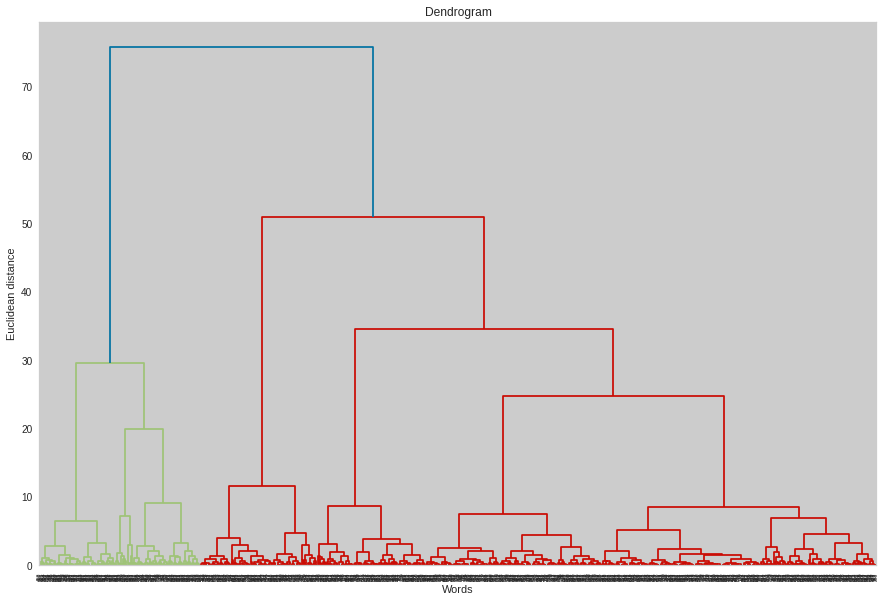

In [49]:
dendrogram(x_bow_pca)

Text(0.5, 0.98, 'HC BOW')

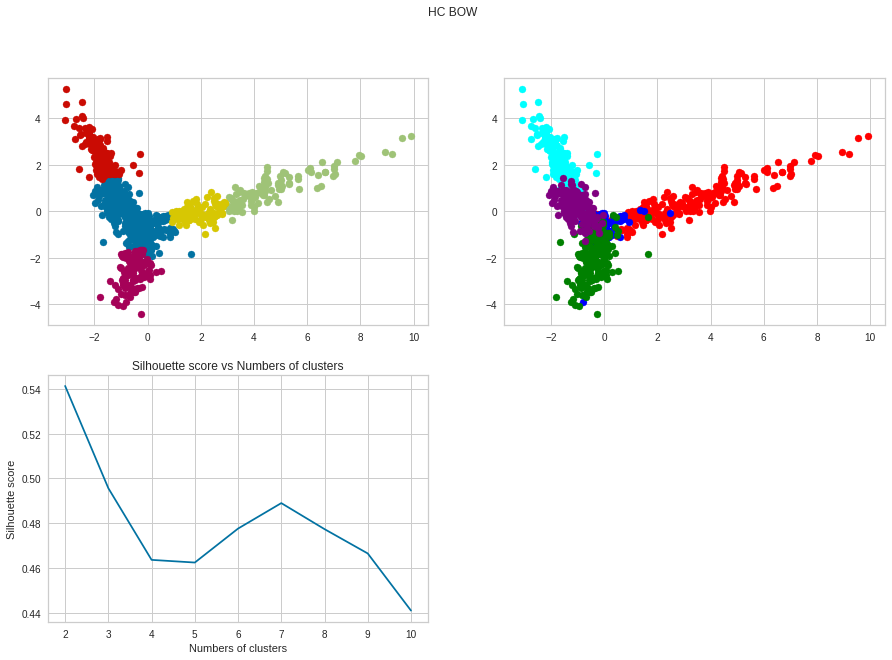

In [50]:
figsize(15,10)
plt.subplot(2,2,1)
HC(5,x_bow_pca)
plt.subplot(2,2,2)
true_label(x_bow_pca,y)
plt.subplot(2,2,3)
Silhouette_hc(x_bow_pca)
plt.suptitle('HC BOW')

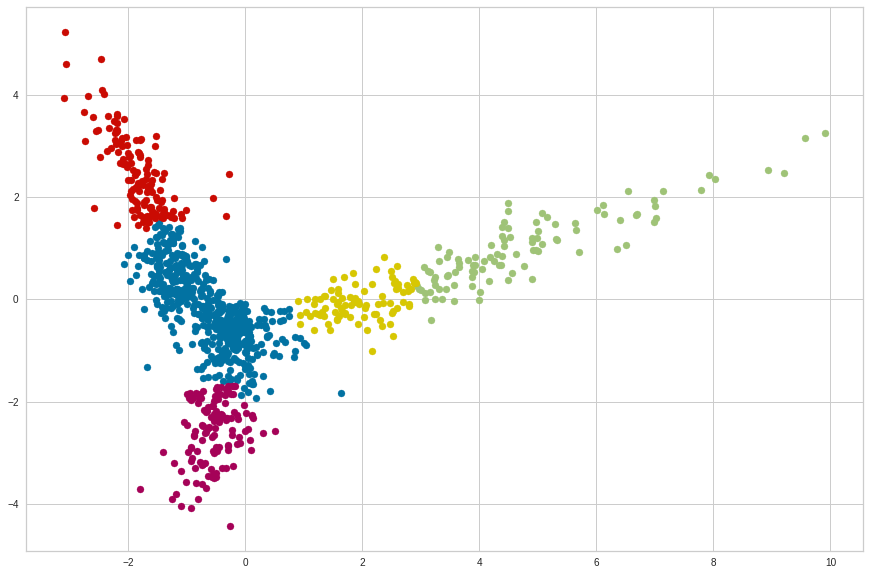

In [51]:
y_hc_bow = HC(5,x_bow_pca)

3.1 tfidf

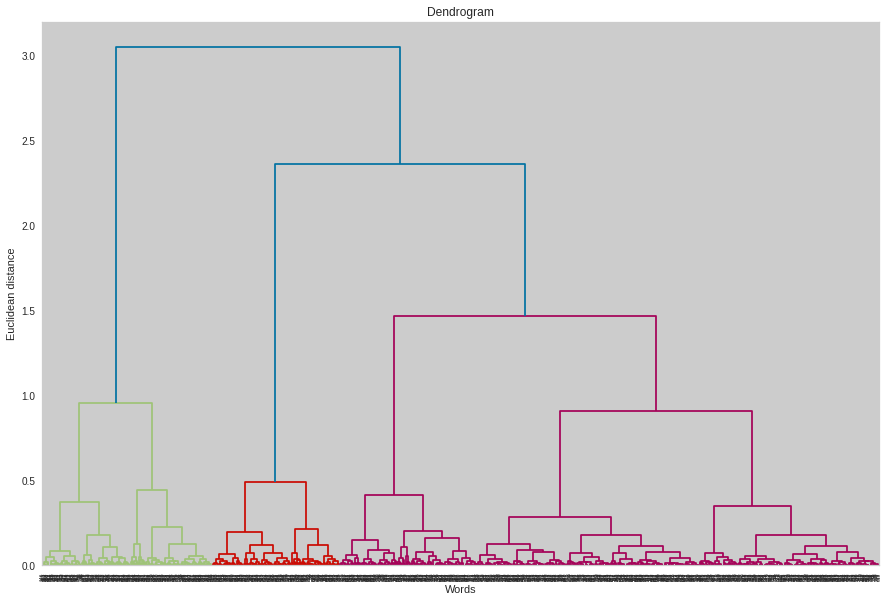

In [52]:
dendrogram(x_tfidf_pca)

Text(0.5, 0.98, 'HC TFIDF')

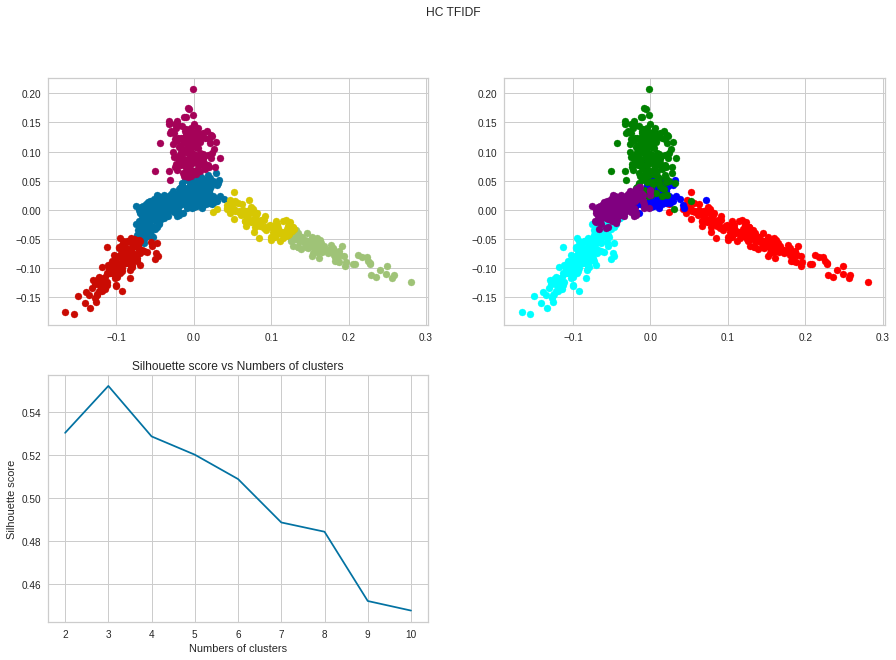

In [53]:
figsize(15,10)
plt.subplot(2,2,1)
HC(5,x_tfidf_pca)
plt.subplot(2,2,2)
true_label(x_tfidf_pca,y)
plt.subplot(2,2,3)
Silhouette_hc(x_tfidf_pca)
plt.suptitle('HC TFIDF')

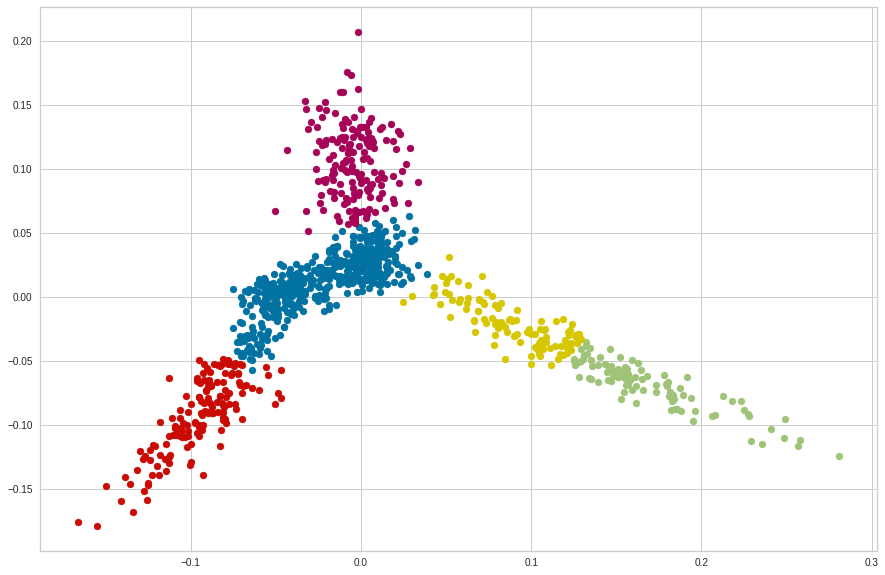

In [54]:
y_hc_tfidf = HC(5,x_tfidf_pca)

3.3 LDA

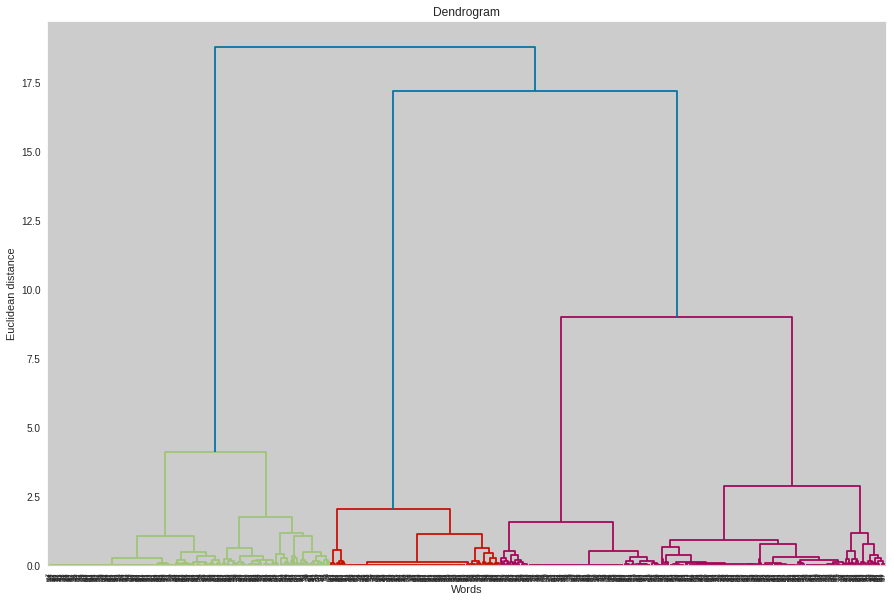

In [55]:
dendrogram(af_pca)

Text(0.5, 0.98, 'HC LDA')

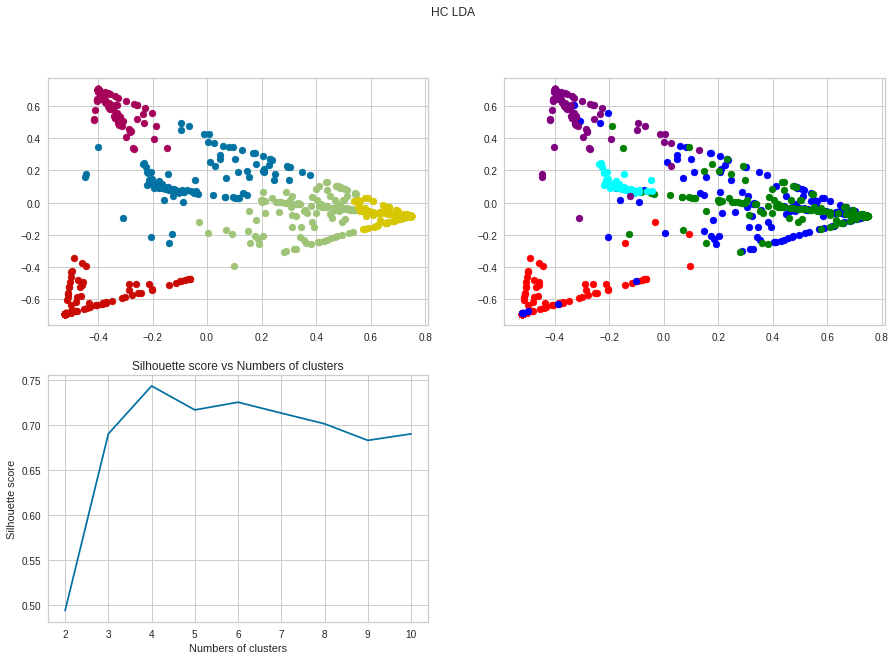

In [56]:
figsize(15,10)
plt.subplot(2,2,1)
HC(5,af_pca)
plt.subplot(2,2,2)
true_label(af_pca,y)
plt.subplot(2,2,3)
Silhouette_hc(af_pca)
plt.suptitle('HC LDA')

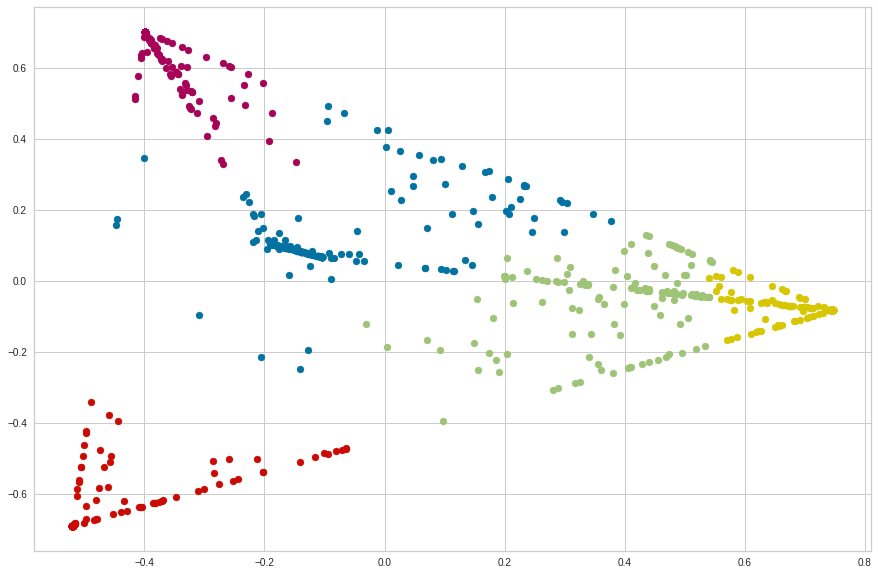

In [57]:
y_hc_lda = HC(5,af_pca)

3.4 word2vec

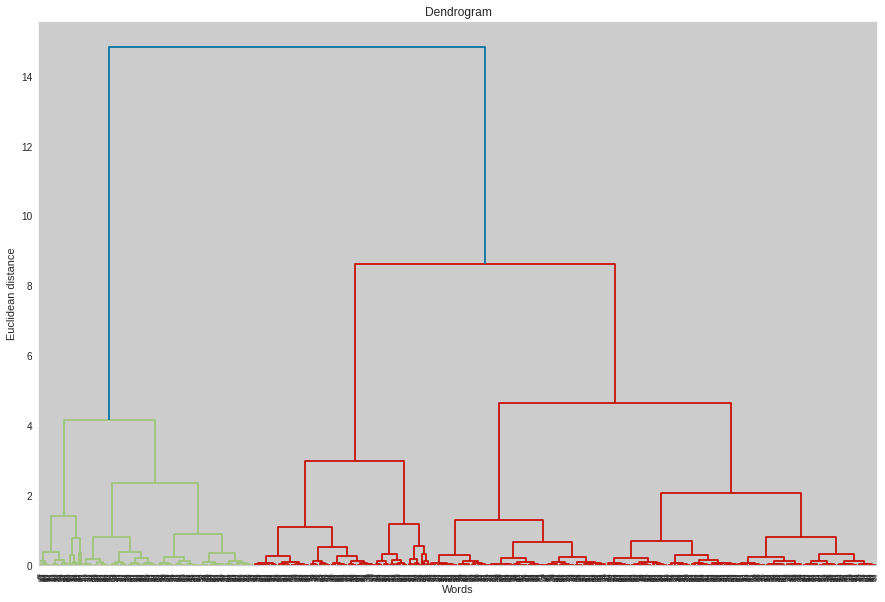

In [58]:
dendrogram(x_word2vec_pca)

Text(0.5, 0.98, 'HC word2vec')

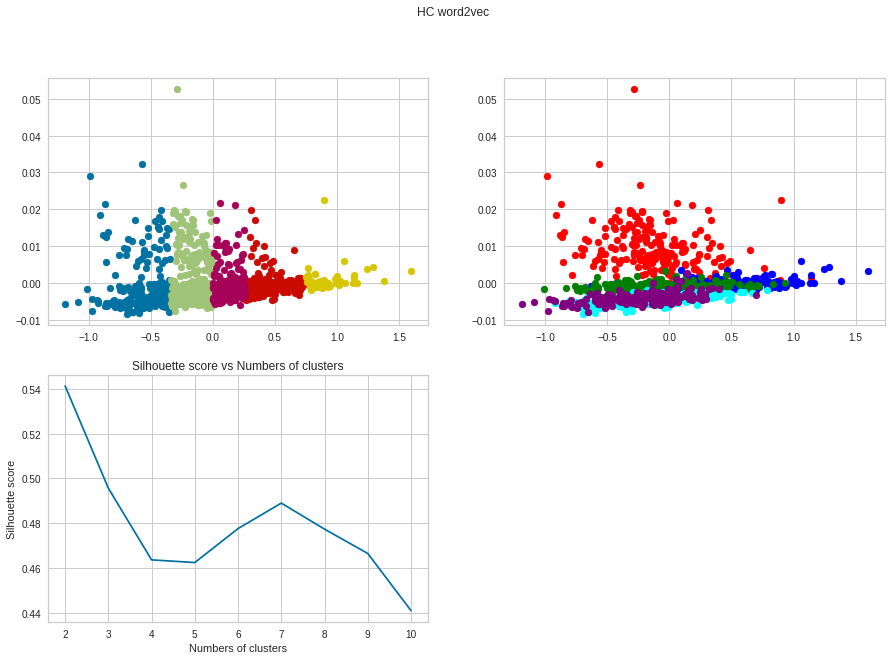

In [59]:
figsize(15,10)
plt.subplot(2,2,1)
HC(5,x_word2vec_pca)
plt.subplot(2,2,2)
true_label(x_word2vec_pca,y)
plt.subplot(2,2,3)
Silhouette_hc(x_bow_pca)
plt.suptitle('HC word2vec')

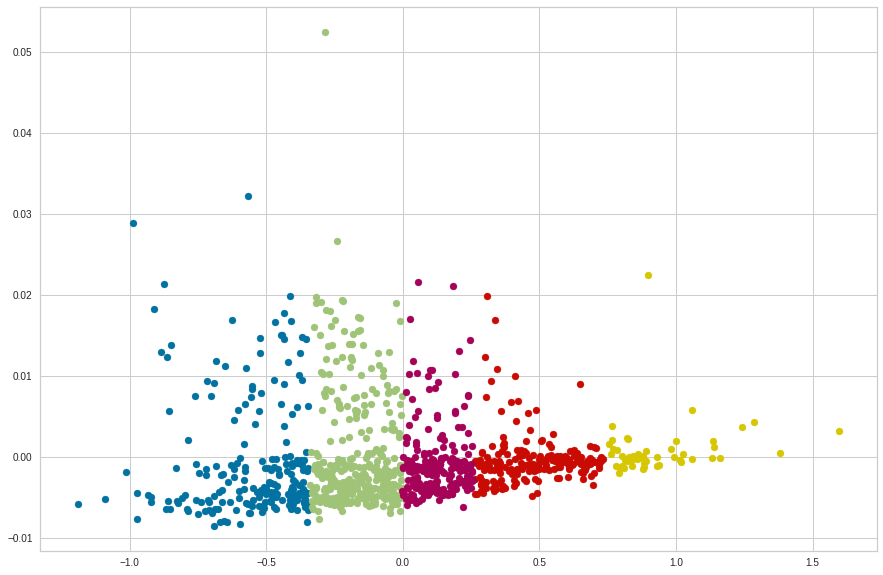

In [60]:
y_hc_word2vec = HC(5,x_word2vec_pca)

## Evaluation

1 Kappa

In [61]:
#Kmeans
kappa_values = []
kappa_keys = []
# 1 BOW

kappa_values.append( cohen_kappa_score(y, y_kmeans_bow))
kappa_values.append( cohen_kappa_score(y, y_kmeans_tfidf))
kappa_values.append( cohen_kappa_score(y, y_kmeans_lda))
kappa_values.append( cohen_kappa_score(y, y_kmeans_word2vec))
kappa_values.append( cohen_kappa_score(y, y_em_bow))
kappa_values.append( cohen_kappa_score(y, y_em_tfidf))
kappa_values.append( cohen_kappa_score(y, y_em_lda))
kappa_values.append( cohen_kappa_score(y, y_em_word2vec))
kappa_values.append( cohen_kappa_score(y, y_hc_bow))
kappa_values.append( cohen_kappa_score(y, y_hc_tfidf))
kappa_values.append( cohen_kappa_score(y, y_hc_lda))
kappa_values.append( cohen_kappa_score(y, y_hc_word2vec))

kappa_keys = ['kmeans_bow','kmeans_tfidf','kmeans_lda','kmeans_word2vec','em_bow','em_tfidf','em_lda','em_word2vec','hc_bow','hc_tfidf','hc_lda','hc_word2vec']
kappa = pd.DataFrame({'Keys':kappa_keys,'Values': kappa_values})
kappa


,Keys,Values
0,kmeans_bow,-0.18500
1,kmeans_tfidf,-0.24500
2,kmeans_lda,-0.02625
3,kmeans_word2vec,-0.07250
4,em_bow,0.29125
5,em_tfidf,0.08625
6,em_lda,0.15875
7,em_word2vec,0.37250
8,hc_bow,-0.23375
9,hc_tfidf,-0.24750


In [62]:
def Silhouette(x,label):
  Silhouette_Score =[]
  for i in range(2, 11):
    hc = AgglomerativeClustering(n_clusters = i, affinity ='euclidean', linkage = 'ward')
    y_hc = hc.fit_predict(x)
    silhouette_avg = silhouette_score(x, y_hc,metric="euclidean",sample_size=1000,random_state=0)
    Silhouette_Score.append(silhouette_avg )
    # print(
    #       "For n_clusters =",
    #       i,
    #       "The average silhouette_score is :",
    #       silhouette_avg,
    #   )
  plt.plot(range(2,11),Silhouette_Score,label = label)
  plt.title('Silhouette score vs Numbers of clusters')
  plt.xlabel('Numbers of clusters')
  plt.ylabel('Silhouette score')
  plt.legend()
  return silhouette_avg

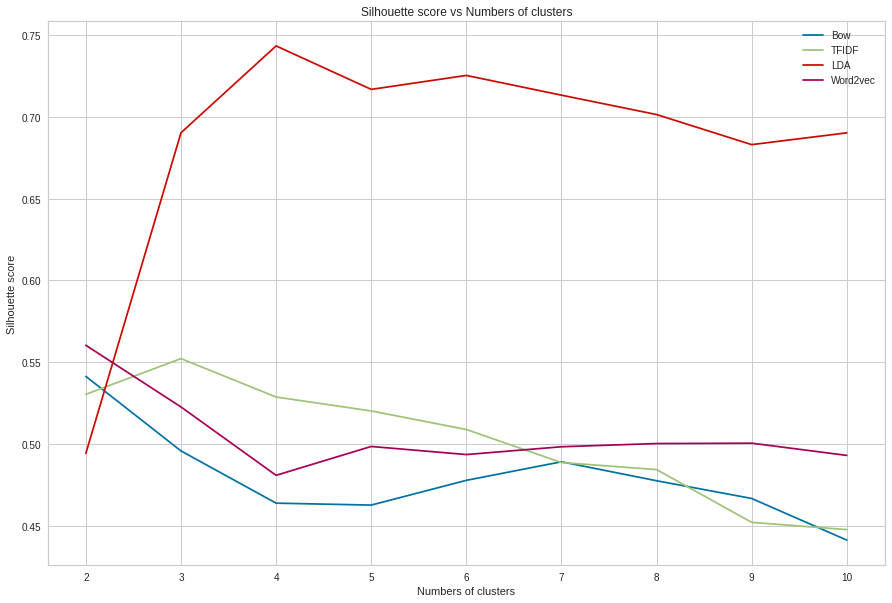

In [63]:
bow =Silhouette(x_bow_pca,'Bow' )
tfidf =Silhouette(x_tfidf_pca,'TFIDF' )
lda =Silhouette(af_pca, 'LDA')
word =Silhouette(x_word2vec_pca,'Word2vec' )

Text(0.5, 1.0, 'Kmeans')

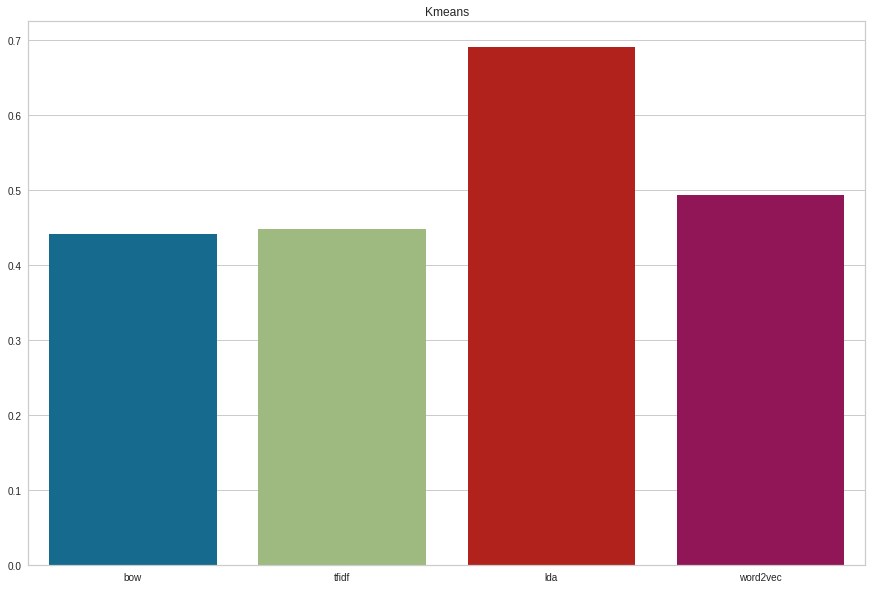

In [64]:
import seaborn as sns
sns.barplot(x=['bow','tfidf','lda','word2vec'],y=[bow,tfidf,lda,word])
plt.title('Kmeans')

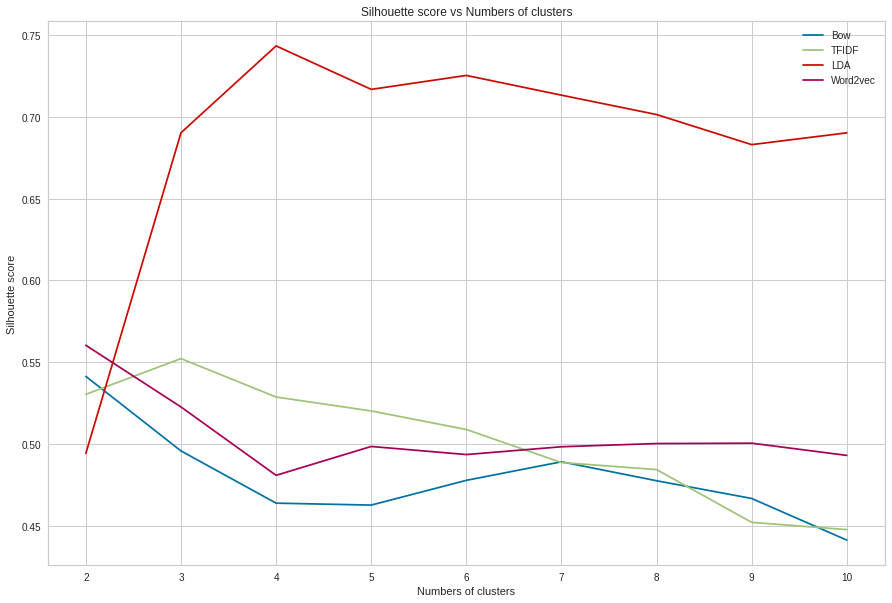

In [67]:
bow =Silhouette(x_bow_pca,'Bow' )
tfidf =Silhouette(x_tfidf_pca,'TFIDF' )
lda =Silhouette(af_pca, 'LDA')
word =Silhouette(x_word2vec_pca,'Word2vec' )

Text(0.5, 1.0, 'EM')

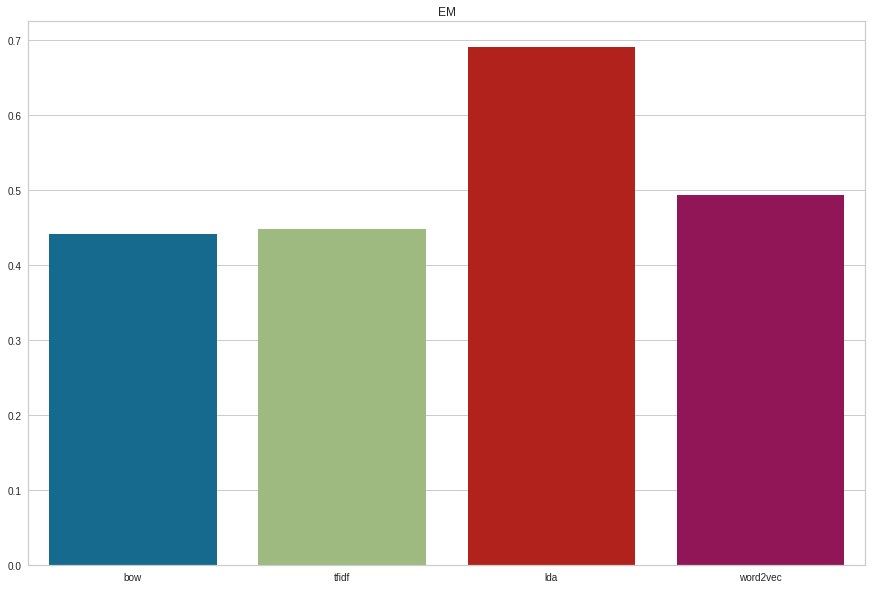

In [68]:
sns.barplot(x=['bow','tfidf','lda','word2vec'],y=[bow,tfidf,lda,word])
plt.title('EM')

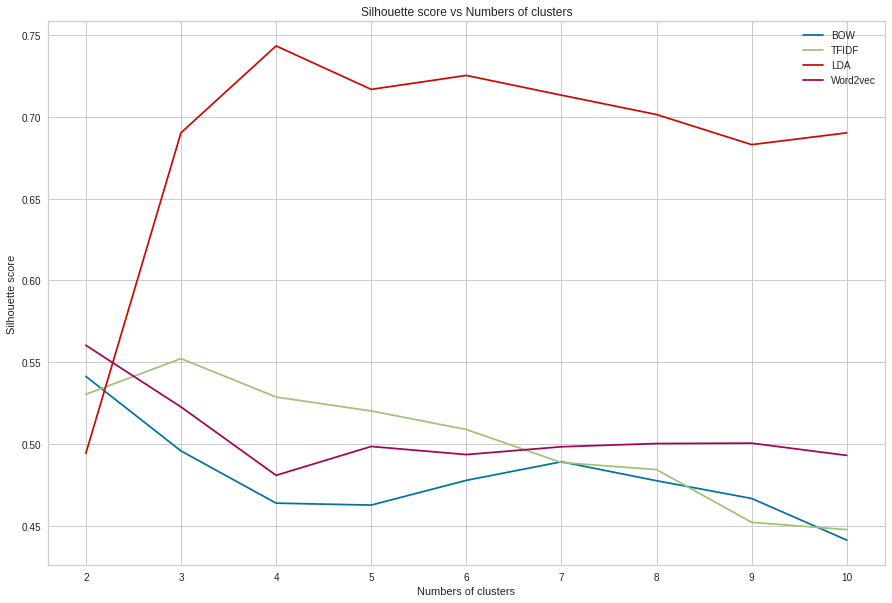

In [69]:
bow =Silhouette(x_bow_pca,'BOW')
tfidf =Silhouette(x_tfidf_pca,'TFIDF')
lda =Silhouette(af_pca,'LDA')
word =Silhouette(x_word2vec_pca,'Word2vec')

Text(0.5, 1.0, 'HC')

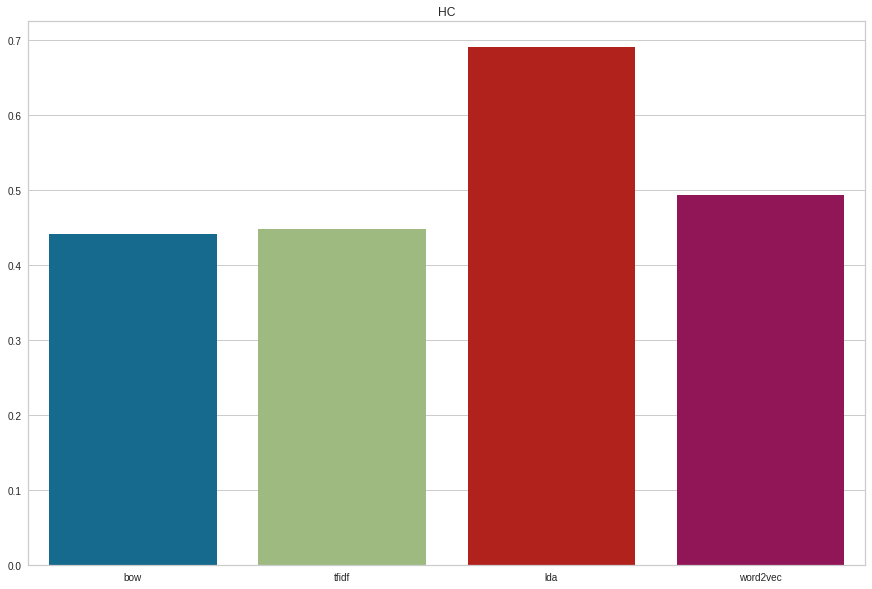

In [70]:
sns.barplot(x=['bow','tfidf','lda','word2vec'],y=[bow,tfidf,lda,word])
plt.title('HC')

2 Coherence

In [71]:
def compute_coherence_values(dictionary,bow_corpus,docs,limit,start =2):
  model =[]
  coherence_value = []
  for num_topics in range(start,limit):  
    ldamodel = LdaModel(corpus=bow_corpus, id2word=dictionary, chunksize =1000, random_state=0,update_every=1, passes =20, alpha='auto',eta='auto', iterations=20, num_topics =num_topics, per_word_topics = True,eval_every = None)
    model.append(ldamodel)
    coherence_ldamodel =CoherenceModel(model=ldamodel, texts=docs, dictionary=dictionary, coherence='c_v')
    coherence_value.append(coherence_ldamodel.get_coherence())
  return model,coherence_value


In [72]:
model,coherence_value = compute_coherence_values(dictionary,bow_corpus,docs,10,2)

In [73]:
coherence_value

[0.34404958363957794,
 0.4646870220183044,
 0.48487501346631845,
 0.5660576116201701,
 0.5321211057502208,
 0.5486372689417927,
 0.5091836430749396,
 0.5076538051848059]

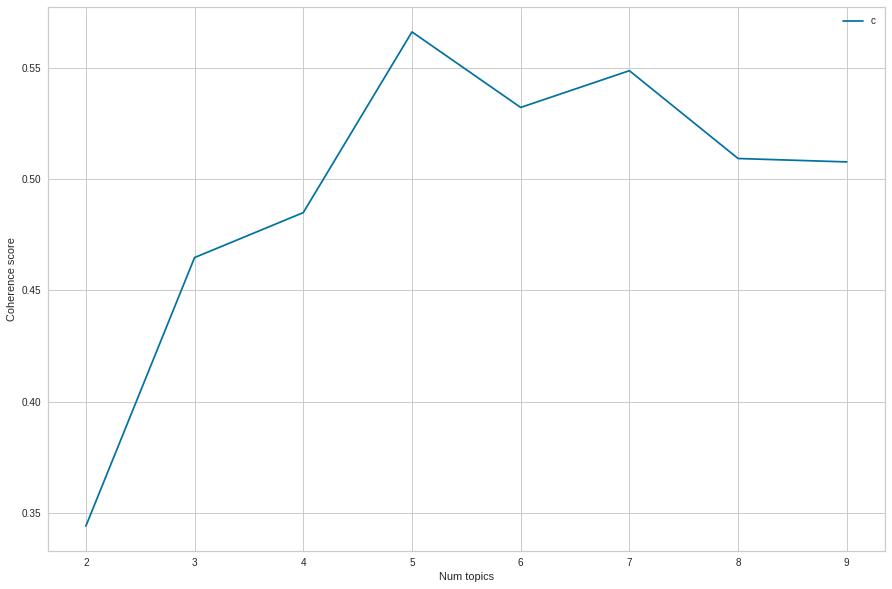

In [74]:
x = range(2,10)
plt.plot(x,coherence_value)
plt.xlabel('Num topics')
plt.ylabel('Coherence score')
plt.legend(("coherence_value"), loc ='best')

3 Silhouette

In [75]:
def visualizer(y):
  fig, ax = plt.subplots(2, 2, figsize=(15,8))
  for i in [2, 3, 4, 5]:
    #Create KMeans instance for different number of clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=1, random_state=100)
    q, mod = divmod(i, 2)
    #Create SilhouetteVisualizer instance with KMeans instance
    #Fit the visualizer
    X=y_kmeans_tfidf.reshape(-1,1)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)

/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/silhouette.py:138: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  self.estimator.fit(X, y, **kwargs)


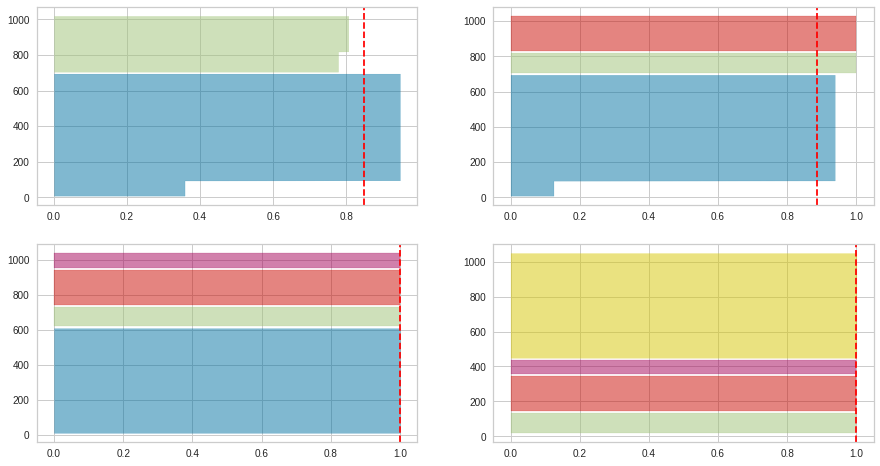

In [76]:
visualizer(y_kmeans_bow)

/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/silhouette.py:138: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  self.estimator.fit(X, y, **kwargs)


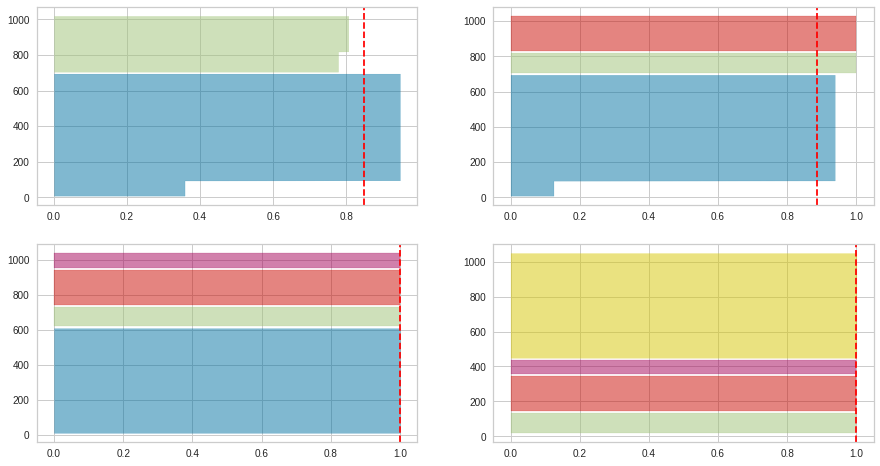

In [77]:
visualizer(y_kmeans_tfidf)

/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/silhouette.py:138: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  self.estimator.fit(X, y, **kwargs)


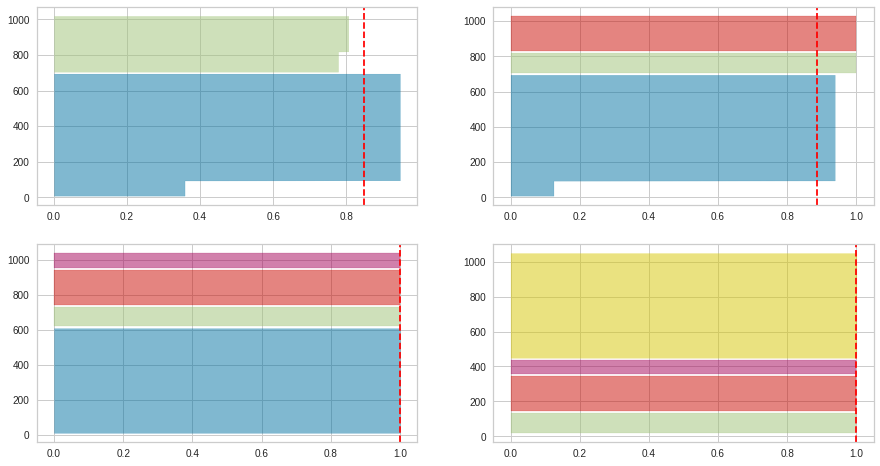

In [78]:
visualizer(y_kmeans_lda)

/usr/local/lib/python3.8/dist-packages/yellowbrick/cluster/silhouette.py:138: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  self.estimator.fit(X, y, **kwargs)


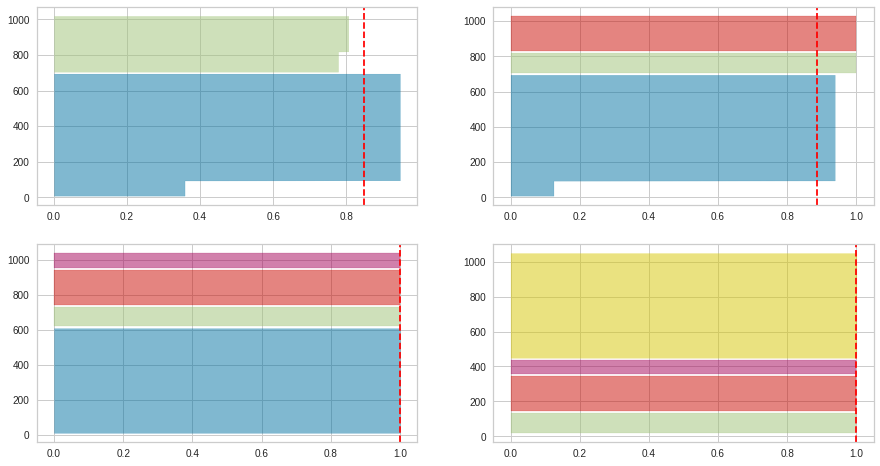

In [79]:
visualizer(y_kmeans_word2vec)

## Error analysis

1 The top 10 frequent words

Text(0.5, 1.0, 'Most common words in The Return of Sherlock Holmes book')

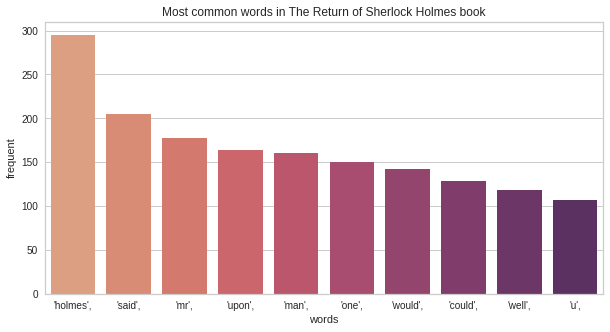

In [80]:
from collections import Counter

book0=[data.iloc[i,1] for i in range(len(data)) if data.iloc[i,0]=='The Return of Sherlock Holmes']
book0=str(book0)
book0 = book0.split(" ")
book0 = Counter(book0).most_common(10)
book0 = pd.DataFrame(book0,columns=['words','frequent'])
figsize(10,5)
sns.barplot(x= 'words',y= 'frequent', data = book0, palette='flare')
plt.title("Most common words in The Return of Sherlock Holmes book")

Text(0.5, 1.0, 'Most common words in the Purple Sages book')

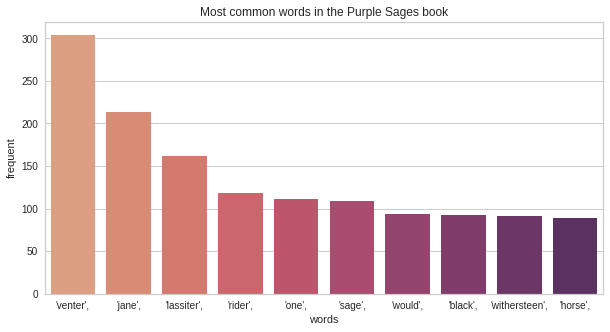

In [81]:
book1=[data.iloc[i,1] for i in range(len(data)) if data.iloc[i,0]=='Riders of the Purple Sage']
book1=str(book1)
book1 = book1.split(" ")
book1 = Counter(book1).most_common(10)
book1 = pd.DataFrame(book1,columns=['words','frequent'])
figsize(10,5)
sns.barplot(x= 'words',y= 'frequent', data = book1, palette='flare')
plt.title("Most common words in the Purple Sages book")

Text(0.5, 1.0, 'Most common words in Myths and Marvels of Astronomy book')

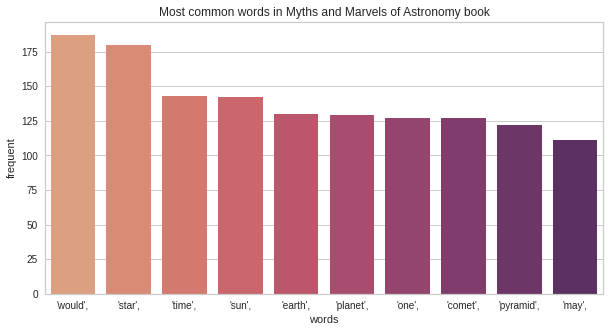

In [82]:
book2=[data.iloc[i,1] for i in range(len(data)) if data.iloc[i,0]=='Myths and Marvels of Astronomy']
book2=str(book2)
book2 = book2.split(" ")
book2 = Counter(book2).most_common(10)
book2 = pd.DataFrame(book2,columns=['words','frequent'])
figsize(10,5)
sns.barplot(x= 'words',y= 'frequent', data = book2, palette='flare')
plt.title("Most common words in Myths and Marvels of Astronomy book")

Text(0.5, 1.0, 'Most common words in The Mysterious Island book')

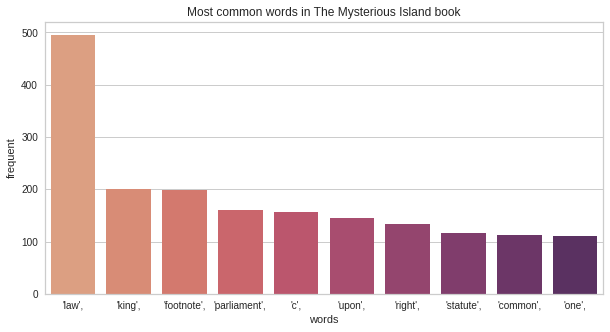

In [83]:
book3=[data.iloc[i,1] for i in range(len(data)) if data.iloc[i,0]=='Commentaries on the Laws of England']
book3=str(book3)
book3 = book3.split(" ")
book3 = Counter(book3).most_common(10)
book3 = pd.DataFrame(book3,columns=['words','frequent'])
figsize(10,5)
sns.barplot(x= 'words',y= 'frequent', data = book3, palette='flare')
plt.title("Most common words in The Mysterious Island book")

Text(0.5, 1.0, 'Most common words in War and Peace book')

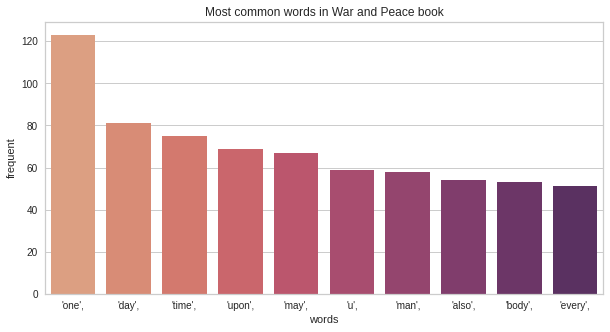

In [84]:
book4=[data.iloc[i,1] for i in range(len(data)) if data.iloc[i,0]=='Curiosities of Medical Experience']
book4=str(book4)
book4 = book4.split(" ")
book4 = Counter(book4).most_common(10)
book4 = pd.DataFrame(book4,columns=['words','frequent'])
figsize(10,5)
sns.barplot(x= 'words',y= 'frequent', data = book4, palette='flare')
plt.title("Most common words in War and Peace book")

2 Top collocations

In [85]:
dataset =data
for i in range(len(dataset)):
  dataset.Words[i] = ' '.join(map(str,dataset.Words[i]))
dataset

,books name,Words
160,The Return of Sherlock Holmes,valuable could find course could definitely pr...
417,Myths and Marvels of Astronomy,little known swedenborg indeed little known as...
522,Myths and Marvels of Astronomy,enlargement idea theological difficulty scienc...
669,Curiosities of Medical Experience,hooped pot shall ten hoop make felony drink sm...
545,The Return of Sherlock Holmes,round spent night town came yesterday report r...
...,...,...
420,The Return of Sherlock Holmes,end building facing way lord saltire bed also ...
762,Myths and Marvels of Astronomy,pierce harvard satisfactorily demonstrated sta...
667,Myths and Marvels of Astronomy,sun though lightly nucleus within mile surface...
635,The Return of Sherlock Holmes,valet maid frequently genteel ruffian gained c...


In [86]:
book0=[dataset.iloc[i,1] for i in range(len(dataset)) if dataset.iloc[i,0]=='The Return of Sherlock Holmes']
book0= str(book0)
book0 = nltk.wordpunct_tokenize(book0)
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder_bigram = BigramCollocationFinder.from_words(book0)
finder_bigram.apply_freq_filter(20)
finder_bigram.nbest(bigram_measures.pmi, 10)

[("',", "'"),
 ('sherlock', 'holmes'),
 ('young', 'man'),
 ('mr', 'holmes'),
 ('said', 'holmes')]

In [87]:
book1=[dataset.iloc[i,1] for i in range(len(dataset)) if dataset.iloc[i,0]=='Riders of the Purple Sage']
book1= str(book1)
book1 = nltk.wordpunct_tokenize(book1)
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder_bigram = BigramCollocationFinder.from_words(book1)
finder_bigram.apply_freq_filter(20)
finder_bigram.nbest(bigram_measures.pmi, 10)

[('jerry', 'card'),
 ('miss', 'withersteen'),
 ('black', 'star'),
 ("',", "'"),
 ('jane', 'withersteen')]

In [88]:
book2=[dataset.iloc[i,1] for i in range(len(dataset)) if dataset.iloc[i,0]=='Myths and Marvels of Astronomy']
book2= str(book2)
book2 = nltk.wordpunct_tokenize(book2)
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder_bigram = BigramCollocationFinder.from_words(book2)
finder_bigram.apply_freq_filter(20)
finder_bigram.nbest(bigram_measures.pmi, 10)

[("',", "'"), ('great', 'pyramid')]

In [89]:
book3=[dataset.iloc[i,1] for i in range(len(dataset)) if dataset.iloc[i,0]=='Commentaries on the Laws of England']
book3= str(book3)
book3 = nltk.wordpunct_tokenize(book3)
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder_bigram = BigramCollocationFinder.from_words(book3)
finder_bigram.apply_freq_filter(20)
finder_bigram.nbest(bigram_measures.pmi, 10)

[("',", "'"),
 ('act', 'parliament'),
 ('municipal', 'law'),
 ('common', 'law'),
 ('c', 'footnote'),
 ('law', 'england')]

In [90]:
book4=[dataset.iloc[i,1] for i in range(len(dataset)) if dataset.iloc[i,0]=='Curiosities of Medical Experience']
book4= str(book4)
book4 = nltk.wordpunct_tokenize(book4)
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder_bigram = BigramCollocationFinder.from_words(book4)
finder_bigram.apply_freq_filter(20)
finder_bigram.nbest(bigram_measures.pmi, 10)

[('tell', 'u'), ("',", "'")]

##The End